# Анализ лояльности пользователей Яндекс Афиши

Выполнил: Силаев Денис

Дата: 12.24.2025

## Введение

Команда маркетинга Яндекс Афиши стремится лучше понимать поведение пользователей платформы и выявлять тех, кто с наибольшей вероятностью возвращается и совершает повторные заказы.  
Для этого необходимо провести исследовательский анализ данных о заказах пользователей.

Результаты исследования помогут:
- выявлять перспективных клиентов и предлагать им персонализированные условия;
- точнее настраивать рекламные кампании на аудитории с высокой вероятностью возврата;
- оптимизировать маркетинговые бюджеты;
- повысить общий уровень удержания пользователей.

---

## Цели и задачи проекта

Провести исследовательский анализ данных лояльности пользователей Яндекс Афиши.  

Задачи:  
- Загрузить данные и познакомиться с их содержимым.    
- Провести предобработку данных.  
- Провести исследовательский анализ данных:  
- Сформулировать выводы по проведённому анализу.   
- Понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. 

---

## Используемые данные

Для анализа поступили данные о Лояльности пользователей Яндекс Афиши. Данные берем из базы данных data-analyst-afisha

Описание базы данных:

- `user_id` — идентификатор пользователя;
- `device_type_canonical` — тип устройства (mobile / desktop);
- `order_id` — идентификатор заказа;
- `order_dt` — дата заказа;
- `order_ts` — дата и время заказа;
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество билетов;
- `days_since_prev` — количество дней с предыдущего заказа;
- `event_id` — идентификатор мероприятия;
- `service_name` — билетный оператор;
- `event_type_main` — тип мероприятия;
- `region_name` — регион проведения;
- `city_name` — город проведения.

---

## Структура исследования

Исследование состоит из следующих этапов:
1. Загрузка данных, знакомство с ними и их предобработка;
2. Предобработка данных;
3. Исследовательский анализ данных;
4. Общие выводы и рекомендации.

---

In [1]:
# Установить SQLAlchemy
!pip install sqlalchemy

In [2]:
# Установить модуль psycopg2
!pip install psycopg2-binary

In [3]:
pip install pandas sqlalchemy psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Импортировать библиотеку pandas
import pandas as pd

In [6]:
# Импортировать библиотеку sqlalchemy
from sqlalchemy import create_engine

In [7]:
# Импортировать библиотеку matplotlib
import matplotlib.pyplot as plt

In [8]:
# Импортировать библиотеку seaborn
!pip install seaborn

In [9]:
# Импорт библиотеки seaborn
import seaborn as sns

In [265]:
# Импорт библиотеки numpy
import numpy as np

In [275]:
pip install phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 667.0/667.0 kB 5.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 6.3 MB/s  0:00:03 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [phik]]
Note: you may need to restart the kernel to use updated packages.


In [277]:
import phik

---

In [10]:
# Записать данные для авторизации
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [11]:
# Сформировать строку для подключения 
connection_string = (
    'postgresql://{}:{}@{}:{}/{}'
    .format(
        db_config['user'],
        db_config['pwd'],
        db_config['host'],
        db_config['port'],
        db_config['db']
    )
)

In [12]:
# Создание объекта engine для подключения к базе данных
engine = create_engine(connection_string)

---

# 1.Загрузка данных и их предобработка

In [13]:
# Сформировать SQL запрос
query = '''
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    (
        p.created_dt_msk::date
        - LAG(p.created_dt_msk::date) OVER (
            PARTITION BY p.user_id
            ORDER BY p.created_dt_msk
        )
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases AS p
INNER JOIN afisha.events AS e
    ON p.event_id = e.event_id
INNER JOIN afisha.city AS c
    ON e.city_id = c.city_id
INNER JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
  AND e.event_type_main != 'фильм'
ORDER BY p.user_id;
'''

In [14]:
# Вывести первые 5 строк таблицы по запросу
df = pd.read_sql_query(
    query,
    con=engine
)

df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [15]:
# Вывести общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [16]:
# Описательная статистика числовых столбцов
df.describe()

,order_id,order_dt,order_ts,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611,290611,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,2024-09-01 22:36:38.741272576,2024-09-02 13:31:19.397730816,625.584360,2.754311,3.222381,438019.834992
min,1.000000e+00,2024-06-01 00:00:00,2024-06-01 00:00:42,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,2024-07-30 00:00:00,2024-07-30 11:53:37.500000,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,2024-09-12 00:00:00,2024-09-12 14:02:10,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,2024-10-09 00:00:00,2024-10-09 15:57:55.500000,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,2024-10-31 00:00:00,2024-10-31 23:59:54,81174.540000,57.000000,148.000000,592325.000000
std,2.497551e+06,NaN,NaN,1227.693064,1.170620,11.350509,147423.078841


#### 📌 Общая информация о данных

В датафрейме 290 611 строк и 15 столбцов, объём данных — около 33 МБ.
Каждая строка соответствует одному заказу пользователя.

Типы данных в целом заданы корректно:

даты (order_dt, order_ts) имеют тип datetime64;

числовые показатели (revenue, tickets_count, days_since_prev) — числовые типы;

категориальные признаки представлены строками (object).

Пропуски есть только в столбце days_since_prev (около 22 тыс. значений), что ожидаемо — это первые заказы пользователей.

#### 📊 Оценка корректности выгрузки

Количество строк и ненулевых значений совпадает для большинства столбцов → выгрузка полная.

Пропуски в days_since_prev логичны и соответствуют условию задачи.

В revenue присутствуют отрицательные значения, что может указывать на возвраты или ошибки.

Есть аномально большие значения выручки (до ~81 тыс.), сильно отличающиеся от среднего.

Диапазон дат: с 01.06.2024 по 31.10.2024, выглядит корректно.

В целом данные выгружены корректно и подходят для анализа.

#### 🛠 Предположения по предобработке данных

На этапе предобработки могут понадобиться следующие шаги:

проверить и обработать отрицательные значения в revenue;

определить, как учитывать пропуски в days_since_prev (например, оставить как есть);

привести категориальные признаки (device_type_canonical, currency_code, event_type_main) к типу category для оптимизации памяти;

проверить данные на дубликаты заказов (order_id);

при необходимости обработать выбросы в выручке.

#### ✅ Итог

Данные имеют достаточный объём, корректную структуру и ожидаемые пропуски.
Датафрейм готов к этапу предобработки и дальнейшему исследовательскому анализу.

---

# 2. Предобработка данных

## 2.1 Привести выручку к единой валюте

In [17]:
# Загрузить датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год
tenge_df = pd.read_csv('final_tickets_tenge_df.csv')

In [18]:
# Проверить, вывести первые 5 строк 
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [19]:
# Преобразовать столбцы с датами к формату datetime для корректного объединения датафреймов
tenge_df['data'] = pd.to_datetime(tenge_df['data'])
df['order_dt'] = pd.to_datetime(df['order_dt'])

In [20]:
# Создать временный датафрейм для расчёта выручки в рублях
df_calc = df.merge(
    tenge_df,
    left_on='order_dt',
    right_on='data',
    how='left'
)


In [21]:
# Проверить
df_calc.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,2024-08-20,100,18.6972,kzt
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,2024-07-23,100,18.3419,kzt
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,2024-10-06,100,19.6475,kzt
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,2024-07-13,100,18.5010,kzt
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,2024-10-04,100,19.6648,kzt


In [22]:
# Пересчитать выручки из тенге в рубли по курсу на дату заказа
# Добавить столбец с выручкой в рублях
df_calc['revenue_rub'] = df_calc['revenue']
# Выбрать строки, где валюта — тенге
mask_kzt = df_calc['currency_code'] == 'kzt'
# Для заказов в тенге пересчитать выручку в рубли:
# умножить сумму выручки на курс и поделить на номинал (100 тенге)
df_calc.loc[mask_kzt, 'revenue_rub'] = (
    df_calc.loc[mask_kzt, 'revenue'] *
    df_calc.loc[mask_kzt, 'curs'] /
    df_calc.loc[mask_kzt, 'nominal']
)

In [23]:
# Добавить столбец revenue_rub в основной датафрейм
df['revenue_rub'] = df_calc['revenue_rub']

Для расчёта выручки в рублях был создан временный датафрейм, объединяющий заказы с курсами валют по дате.
После выполнения вычислений в основной датафрейм был добавлен только итоговый столбец revenue_rub.

In [24]:
# Проверить что новый столец добвился в df (вывести рандомные строки что бы в столбце currency_code попались тенге
df[['currency_code', 'revenue', 'revenue_rub']].sample(15)

,currency_code,revenue,revenue_rub
189561,rub,710.41,710.410000
87219,rub,85.50,85.500000
261698,rub,375.60,375.600000
167504,rub,1940.61,1940.610000
124375,kzt,6892.13,1359.948199
133167,rub,356.05,356.050000
244441,rub,869.56,869.560000
57504,rub,1332.42,1332.420000
7762,rub,454.41,454.410000
241507,rub,148.04,148.040000


In [25]:
# Проверить корректности пересчёта выручки по валютам
df.groupby('currency_code', observed=True)[['revenue', 'revenue_rub']].mean()

,revenue,revenue_rub
currency_code,,
kzt,4995.206767,981.325159
rub,548.013929,548.013929


Для проверки корректности пересчёта выручки были рассчитаны средние значения выручки до и после преобразования в разрезе валют. Для заказов, оплаченных в рублях, значения выручки не изменились. Для заказов в казахстанских тенге значения выручки были корректно пересчитаны в рубли с учётом курса и номинала на дату заказа.

---

## 2.2 Проверить пропущеные значения

In [26]:
# Проверить колличество пропущенных значений в каждом столбце
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [27]:
# Подсчитать долю строк с пропусками в процентах
missing_share = df.isna().mean() * 100
missing_share

user_id                  0.000000
device_type_canonical    0.000000
order_id                 0.000000
order_dt                 0.000000
order_ts                 0.000000
currency_code            0.000000
revenue                  0.000000
tickets_count            0.000000
days_since_prev          7.547202
event_id                 0.000000
event_name               0.000000
event_type_main          0.000000
service_name             0.000000
region_name              0.000000
city_name                0.000000
revenue_rub              0.000000
dtype: float64

В датасете отсутствуют пропуски по всем ключевым и категориальным столбцам, за исключением days_since_prev.
Доля пропусков в этом поле составляет 7.55%, что соответствует первому заказу пользователя, для которого невозможно рассчитать интервал с предыдущей покупкой.
Такие пропуски являются ожидаемыми и корректными, удаление строк не требуется. Столбец может использоваться в анализе с учётом этого ограничения.

## 2.3 Преобразовать типы данных

In [28]:
# Проверить типы данных в кажом столбце
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Категориальные столбцы (device_type_canonical, currency_code, event_name, event_type_main, service_name, region_name, city_name) имеют тип object и должны быть приведены к category для оптимизации памяти.

Числовые столбцы (revenue, revenue_rub, days_since_prev, tickets_count) содержат избыточные типы данных и подлежат сжатию без потери точности.

В столбце days_since_prev присутствуют пропуски, что является ожидаемым поведением (первый заказ пользователя), но требует учёта при анализе.

Столбцы с датой и временем (order_dt, order_ts) имеют корректный формат, дополнительной обработки не требуют.

In [29]:
# Количество билетов в заказе — всегда целое и небольшое число 
# int16 достаточно (экономит память по сравнению с int64)
df['tickets_count'] = df['tickets_count'].astype('int16')

In [30]:
# Количество дней с предыдущей покупки
# Есть пропуски (NaN), поэтому используем float
# float32 вместо float64 — меньше памяти, точности достаточно
df['days_since_prev'] = df['days_since_prev'].astype('float32')

In [31]:
# Выручка в исходной валюте
# Денежные значения не требуют двойной точности float64
# float32 достаточно для аналитических расчётов
df['revenue'] = df['revenue'].astype('float32')

In [32]:
# Выручка, приведённая к рублям
# Аналогично: уменьшаем размерность до float32
df['revenue_rub'] = df['revenue_rub'].astype('float32')

In [33]:
# Тип устройства (mobile / desktop) → мало уникальных значений, экономим память
df['device_type_canonical'] = df['device_type_canonical'].astype('category')

In [34]:
# Валюта заказа (rub / kzt) → категориальный признак, строки не нужны
df['currency_code'] = df['currency_code'].astype('category')

In [35]:
# Тип мероприятия → используется для группировок и аналитики
df['event_type_main'] = df['event_type_main'].astype('category')

In [36]:
# Билетный оператор → справочный столбец с повторами
df['service_name'] = df['service_name'].astype('category')

In [37]:
# Регион проведения → географическая категория
df['region_name'] = df['region_name'].astype('category')

In [38]:
# Город проведения → категориальный геопризнак
df['city_name'] = df['city_name'].astype('category')

In [39]:
# Название мероприятия → повторяющиеся значения, не текстовый анализ
df['event_name'] = df['event_name'].astype('category')

In [40]:
# Проверить преобразования
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  category      
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  category      
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int16         
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  category      
 11  event_type_main        290611 non-null  category      
 12  service_name           290611 non-null  cate

📌 Промежуточный вывод после преобразования типов

В ходе предобработки данных были оптимизированы типы столбцов для снижения объёма памяти и повышения эффективности дальнейшего анализа.

Основные изменения:

Номинальные признаки (device_type_canonical, currency_code, event_name, event_type_main, service_name, region_name, city_name) переведены в тип category.

Числовые столбцы приведены к более компактным типам:

revenue, revenue_rub, days_since_prev → float32

tickets_count → int16

Даты и время (order_dt, order_ts) сохранены в формате datetime64[ns], так как они используются для временного анализа.

Столбец days_since_prev содержит пропуски (около 22 тыс. строк), что корректно и соответствует пользователям с одной покупкой.

Остальные столбцы не содержат пропущенных значений.

Результат оптимизации:

Объём памяти датафрейма уменьшился с ~35.5 МБ до ~18.1 МБ, то есть почти в 2 раза, без потери информации.

## 2.4 Изучить значения в ключевых столбцах

#### Ключевыми столбцами датасета являются

База для возврата/поведения:

`user_id`, `order_id`, `order_dt`, `order_ts`, `days_since_prev`, `tickets_count`

Факторы/сегментация:

`device_type_canonical`, `event_type_main`, `region_name`, `city_name`)

Ценность для маркетинга:

`revenue_rub`

In [41]:
# уникальность заказов
df['order_id'].nunique(), len(df)

(290611, 290611)

Проверена уникальность идентификатора заказа. Количество уникальных order_id совпадает с числом строк в датафрейме (287 786), что подтверждает отсутствие дубликатов заказов.

In [42]:
# количество покупок на пользователя
df['user_id'].value_counts().describe()

count    21933.000000
mean        13.249943
std        122.470535
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10251.000000
Name: count, dtype: float64

Анализ количества покупок на пользователя показал сильную асимметрию распределения. Медианное значение составляет 2 покупки, при этом 75% пользователей совершают не более 5 покупок. Наблюдаются экстремальные выбросы (до 10 181 покупки на одного пользователя), что указывает на наличие сверхактивных или нетипичных аккаунтов.

In [43]:
# пропуски в days_since_prev
df['days_since_prev'].isna().mean()

np.float64(0.07547202273829966)

В столбце days_since_prev обнаружены пропуски в 7.55% наблюдений. Они соответствуют пользователям с первой покупкой и являются ожидаемыми, поэтому дополнительной обработки не требуют.

In [44]:
# Проверка дат и времени
df[['order_dt', 'order_ts']].describe()

,order_dt,order_ts
count,290611,290611
mean,2024-09-01 22:36:38.741272576,2024-09-02 13:31:19.397730816
min,2024-06-01 00:00:00,2024-06-01 00:00:42
25%,2024-07-30 00:00:00,2024-07-30 11:53:37.500000
50%,2024-09-12 00:00:00,2024-09-12 14:02:10
75%,2024-10-09 00:00:00,2024-10-09 15:57:55.500000
max,2024-10-31 00:00:00,2024-10-31 23:59:54


Проверка столбцов с датой и временем показала, что данные охватывают период с 1 июня по 31 октября 2024 года. Значения в order_dt представлены в формате календарной даты без времени, а order_ts содержит корректные временные метки в пределах суток. Аномалий и некорректных значений не выявлено.

In [45]:
# Провести анализ категориальныъ столбцов
for col in ['device_type_canonical', 'event_type_main', 'region_name', 'city_name']:
    print(col)
    print(df[col].value_counts().head(10))
    print()
    
df[col].isna().sum()

device_type_canonical
device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64

event_type_main
event_type_main
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: count, dtype: int64

region_name
region_name
Каменевский регион         91058
Североярская область       44049
Широковская область        16457
Медовская область          13901
Озернинский край           10476
Светополянский округ        7607
Малиновоярский округ        6618
Речиновская область         6293
Солнечноземская область     6288
Яблоневская область         6181
Name: count, dtype: int64

city_name
city_name
Глиногорск      89446
Озёрск          43910
Радужсвет       13711
Радужнополье     8741
Верховино        6579
Дальнесветск     6293
Глинополье       6196
Светополье       5993
Глиноград        5934
Лесоярич         5831
Name: count, dtype: int64



np.int64(0)

В категориальных столбцах device_type_canonical, event_type_main, region_name и city_name были проанализированы уникальные значения. Пропущенные значения и категории, обозначающие отсутствие данных, не выявлены. Все значения выглядят корректно и не требуют дополнительной нормализации. Распределения категорий неравномерны, что отражает реальные различия в пользовательском поведении и географии заказов.

In [46]:
# Описательная статистика tickets_count
df['tickets_count'].describe()

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

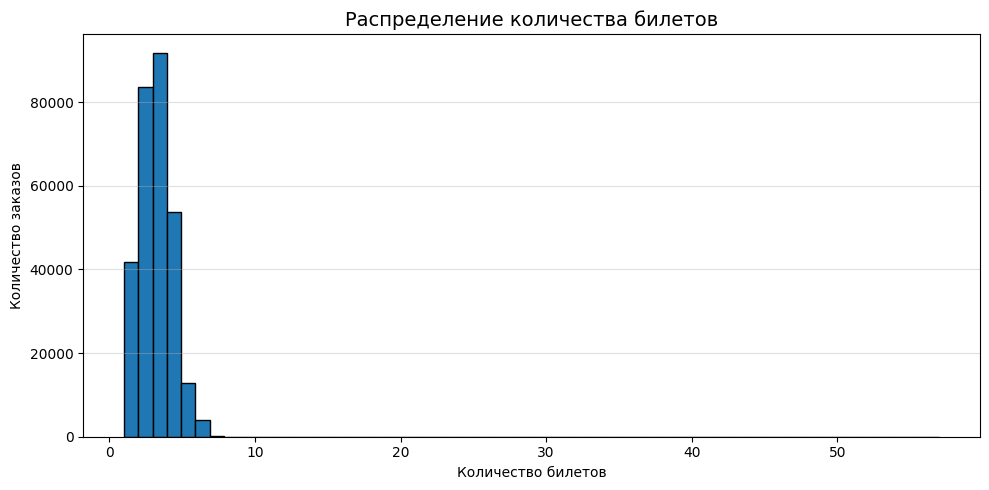

In [301]:
# Построим гистограмму
plt.figure(figsize=(10, 5))
plt.hist(
    df['tickets_count'],
    bins=df['tickets_count'].max(),
    edgecolor='black'
)

plt.title('Распределение количества билетов', fontsize=14)
plt.xlabel('Количество билетов')
plt.ylabel('Количество заказов')
plt.grid(axis='y', alpha=0.4)

plt.tight_layout()
plt.show()

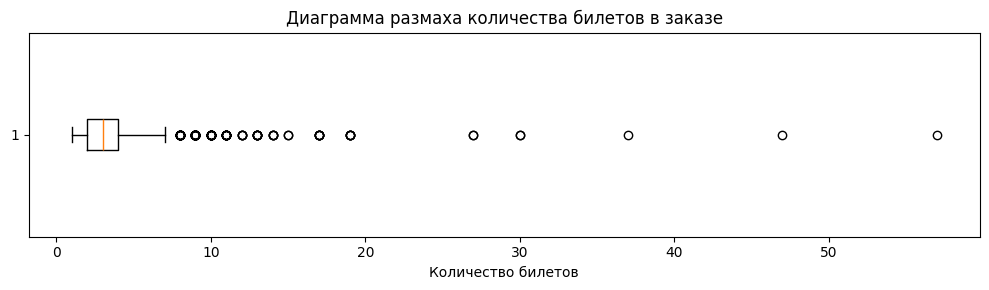

In [48]:
# Построим диаграмму размаха
plt.figure(figsize=(10, 3))

plt.boxplot(df['tickets_count'], vert=False)

plt.title('Диаграмма размаха количества билетов в заказе')
plt.xlabel('Количество билетов')

plt.tight_layout()
plt.show()

Распределение количества билетов в заказе имеет выраженную концентрацию в диапазоне 2–4 билета: медианное значение равно 3, межквартильный размах составляет [2; 4]. Минимальное значение (1 билет) является корректным и соответствует одиночным покупкам.

По гистограмме и диаграмме размаха видно, что распределение асимметрично и имеет правосторонний хвост, сформированный редкими заказами с большим количеством билетов. Большинство наблюдений сосредоточено в области до 6 билетов, тогда как значения выше этого порога встречаются значительно реже.

Максимальное значение (57 билетов) относится к единичным выбросам и, вероятно, связано с групповыми или корпоративными покупками. Такие значения не выглядят ошибочными, поэтому исключать их из анализа не требуется.

In [49]:
# Описательная статистика выручки заказа (revenue_rub)
df['revenue_rub'].describe()

count    290611.000000
mean        555.571960
std         875.498169
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

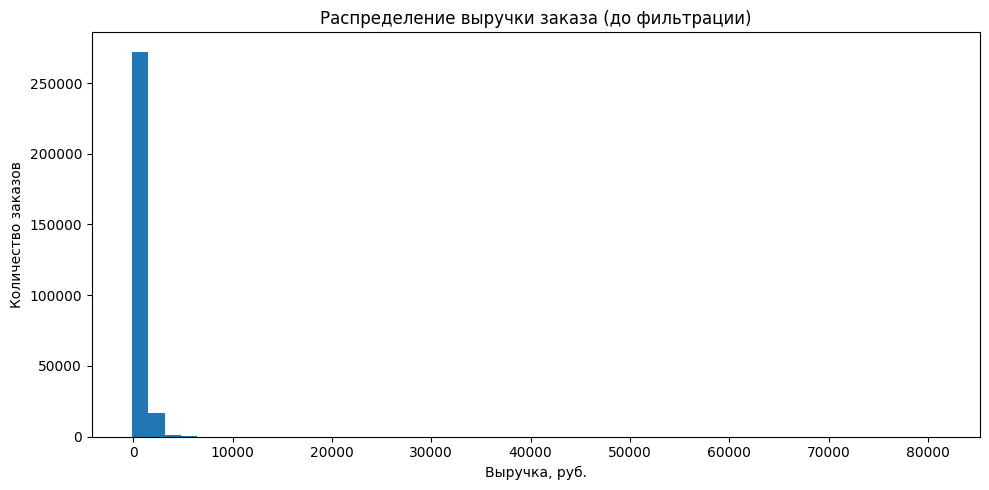

In [50]:
# Построить гистограмму
plt.figure(figsize=(10, 5))

plt.hist(df['revenue_rub'], bins=50)
plt.title('Распределение выручки заказа (до фильтрации)')
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество заказов')

plt.tight_layout()
plt.show()

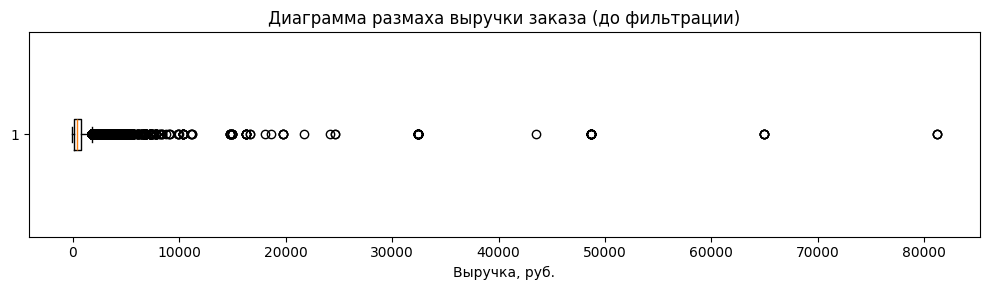

In [51]:
# Построить диаграмму размаха (boxplot)
plt.figure(figsize=(10, 3))

plt.boxplot(df['revenue_rub'], vert=False)

plt.title('Диаграмма размаха выручки заказа (до фильтрации)')
plt.xlabel('Выручка, руб.')

plt.tight_layout()
plt.show()

Распределение выручки заказа имеет выраженную правостороннюю асимметрию: основная масса заказов приходится на небольшие суммы, тогда как небольшое число заказов с очень высокой выручкой формирует длинный правый хвост распределения. Это подтверждается тем, что медиана выручки (≈ 351 руб.) значительно ниже среднего значения (≈ 556 руб.), что указывает на сильное влияние крупных заказов на среднее значение.

Диаграмма размаха демонстрирует узкий межквартильный размах: 50% заказов находятся в диапазоне от ≈ 114 до ≈ 802 руб. При этом наблюдается большое количество значений, существенно превышающих верхний квартиль, включая редкие экстремальные наблюдения с выручкой до ≈ 81 174 руб. Наличие таких значений существенно искажает визуализацию распределения в полном диапазоне.

Также в данных присутствуют отрицательные значения выручки (до ≈ −90,8 руб.), что, вероятно, связано с возвратами или корректировками и не является ошибкой данных, однако требует отдельного учета при дальнейшем анализе.

В целом показатель revenue_rub характеризуется высокой вариативностью и наличием экстремальных значений, что обосновывает необходимость последующей обработки выбросов и анализа распределения после их фильтрации.

## 2.5 Поиск и фильтрация выбросов по revenue_rub (99 перцентиль)

In [52]:
# Сохраняем исходное количество строк до фильтрации
rows_before = df.shape[0]
rows_before

290611

In [53]:
# Рассчитываем 99-й перцентиль выручки в рублях
revenue_99 = df['revenue_rub'].quantile(0.99)
revenue_99

np.float32(2628.4216)

In [54]:
# Фильтруем датафрейм, убирая заказы с аномально высокой выручкой
df = df[df['revenue_rub'] <= revenue_99]

In [55]:
# Количество строк после фильтрации
rows_after = df.shape[0]
rows_after

287786

In [56]:
# Считаем, сколько строк и какой процент данных было удалено
filtered_rows = rows_before - rows_after
filtered_share = filtered_rows / rows_before * 100

rows_before, rows_after, filtered_rows, round(filtered_share, 2)


(290611, 287786, 2825, 0.97)

In [57]:
# Описательная статистика выручки заказа (revenue_rub) после фильтрации
df['revenue_rub'].describe()

count    287786.000000
mean        518.029236
std         511.963776
min         -90.760002
25%         111.849998
50%         343.849976
75%         788.659973
max        2628.421631
Name: revenue_rub, dtype: float64

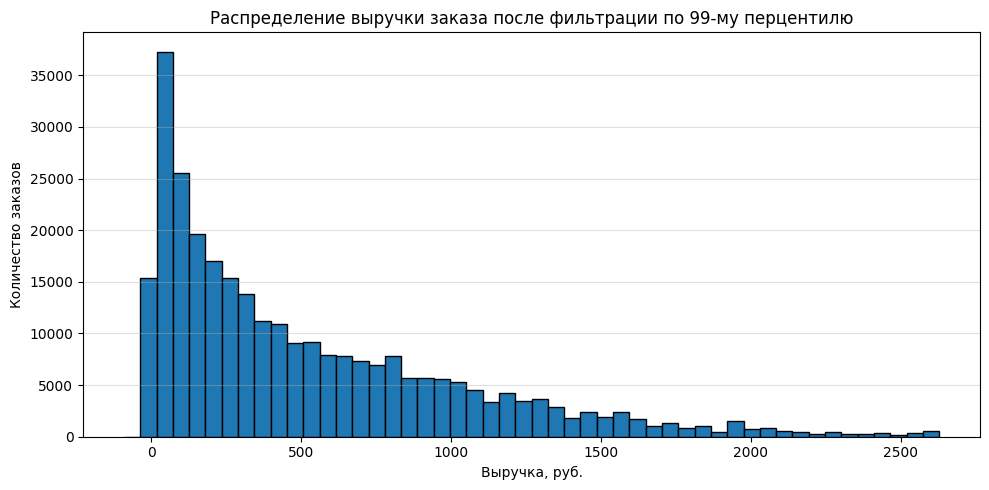

In [58]:
# Изучить график после фильтрации
plt.figure(figsize=(10, 5))

plt.hist(
    df['revenue_rub'],
    bins=50,
    edgecolor='black'
)

plt.title('Распределение выручки заказа после фильтрации по 99-му перцентилю')
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество заказов')
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

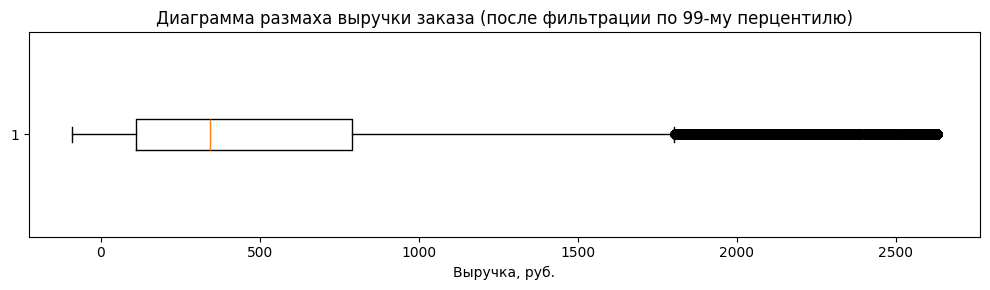

In [59]:
# boxplot после фильтрации
plt.figure(figsize=(10, 3))

plt.boxplot(df['revenue_rub'], vert=False)

plt.title('Диаграмма размаха выручки заказа (после фильтрации по 99-му перцентилю)')
plt.xlabel('Выручка, руб.')

plt.tight_layout()
plt.show()

После фильтрации значений выручки заказа по 99-му перцентилю (порог ≈ 2628 руб.) из датасета было удалено менее 1% наблюдений, что позволило снизить влияние экстремально дорогих заказов при сохранении основной массы данных. В результате распределение выручки стало более наглядным и интерпретируемым.

Распределение revenue_rub по-прежнему имеет выраженную правостороннюю асимметрию: медиана выручки (≈ 344 руб.) заметно ниже среднего значения (≈ 518 руб.), что указывает на наличие редких, но более дорогих заказов, оказывающих влияние на среднее. Основная часть заказов сосредоточена в диапазоне до 800 руб., что подтверждается межквартильным размахом (Q1 ≈ 112 руб., Q3 ≈ 789 руб.).

Диаграмма размаха после фильтрации стала значительно более информативной: коробка и медиана хорошо различимы, а экстремальные выбросы существенно сокращены. При этом в правой части распределения сохраняется группа значений, формально определяемых как выбросы по критерию 1.5×IQR. Эти наблюдения отражают естественную неоднородность стоимости заказов и не являются ошибками данных.

Наличие небольшого числа отрицательных значений выручки (до ≈ −90,8 руб.) вероятнее всего связано с возвратами или корректировками и требует отдельного учета в дальнейшем анализе, однако не искажает общую структуру распределения.

В целом проведённая фильтрация позволила очистить данные от экстремальных значений, улучшить визуализацию распределения и создать корректную основу для дальнейшего анализа, при котором целесообразно опираться на устойчивые статистики (медиану и межквартильный размах), а не на среднее значение.


## 2.6 Промежуточный общий вывод по предобработке и первичному анализу данных

В рамках предобработки датасета заказов (изначально **290 611** строк) выполнены ключевые шаги подготовки данных к анализу.

### 1) Приведение выручки к единой валюте и новый столбец
Так как выручка представлена в **RUB** и **KZT**, значения в тенге были конвертированы в рубли по курсу на дату заказа (курс задан за **100 KZT**). Результат сохранён в новом столбце **`revenue_rub`** и добавлен в основной датафрейм. После расчёта пропусков в `revenue_rub` не обнаружено.

### 2) Пропуски
Проверка пропусков показала, что **NaN присутствуют только в `days_since_prev`**:  
**268 678** non-null из **290 611**, то есть пропуски составляют около **7.55%**. Это ожидаемо: для пользователей с первой покупкой интервал до предыдущего заказа не вычисляется.

### 3) Оптимизация типов данных
Для ускорения работы и снижения потребления памяти выполнено приведение типов:
- категориальные признаки переведены в `category` (например: `device_type_canonical`, `currency_code`, `event_name`, `event_type_main`, `service_name`, `region_name`, `city_name`);
- числовые признаки оптимизированы: `revenue`, `revenue_rub`, `days_since_prev → float32`, `tickets_count → int16`;
- даты сохранены в `datetime64[ns]` (`order_dt`, `order_ts`).

В результате объём памяти датафрейма уменьшился примерно с **~35.5 МБ до ~18.1 МБ** (почти в 2 раза) без потери информации.

### 4) Категориальные признаки (структура данных)
Распределения категорий логичные, “скрытых пропусков” (типа *unknown/none/нет данных*) в топ-категориях не выявлено:
- устройства: **mobile — 230 460**, **desktop — 57 326**;
- типы событий: лидируют **концерты (113 467)** и **театр (66 728)**, далее **другое (65 606)**;
- регионы и города имеют выраженную концентрацию (например, топ-регионы: Каменевский регион и Североярская область; топ-город: Глиногорск).

### 5) Числовые признаки и выбросы
**tickets_count:** распределение сосредоточено на малых значениях (типичные заказы):
- медиана **3**, квартильный диапазон **2–4**, среднее **2.75**;
- максимум **57** — редкие крупные заказы (естественные выбросы, вероятно групповые покупки).

**revenue_rub:** до фильтрации наблюдались экстремальные значения (максимум доходил до **81 174 руб.**), из-за чего гистограмма и boxplot были “сжаты” и плохо интерпретировались.

### 6) Фильтрация выбросов по 99-му перцентилю (revenue_rub)
По условию задачи выручка была отфильтрована по **99-му перцентилю**: порог **≈ 2628 руб.**  
После фильтрации осталось **287 786** строк, то есть удалено **2 825** наблюдений (**≈ 0.97%** данных). Это действительно “менее 1%”, при этом основная масса данных сохранена.

После фильтрации распределение `revenue_rub` стало заметно более читаемым:
- сохраняется правосторонняя асимметрия: медиана **≈ 344 руб.** ниже среднего **≈ 518 руб.**;
- 50% заказов лежат в интервале **Q1 ≈ 112 руб. — Q3 ≈ 789 руб.**;
- максимум после фильтрации **≈ 2628 руб.**, что убрало экстремальные пики и сделало boxplot информативным.
При этом небольшие отрицательные значения (**до ≈ −90.8 руб.**) вероятнее всего связаны с возвратами/корректировками и не являются ошибкой, но их стоит учитывать отдельно в дальнейших выводах.


### Итог
Данные успешно подготовлены к дальнейшему анализу: выручка приведена к единой валюте (`revenue_rub`), пропуски подтверждены как ожидаемые (только `days_since_prev`), типы оптимизированы (память снижена почти в 2 раза), проведён первичный анализ категорий и численных признаков, а также выполнена фильтрация экстремальных выбросов по `revenue_rub` (удалено ~0.97% наблюдений). Полученный датасет корректен и удобен для последующих аналитических шагов.


---

# 3. Создание профиля пользователя

## 3.1 Построение профиля пользователя
На данном этапе формируется агрегированный профиль пользователя, который в дальнейшем будет использоваться для анализа клиентского поведения и построения модели прогнозирования возврата пользователей.

Профиль пользователя строится на основе истории заказов и включает следующие группы признаков:

**1. Характеристики первого и последнего заказа**
- дата первого заказа;
- дата последнего заказа.

**2. Контекст первого взаимодействия пользователя**
- устройство, с которого был оформлен первый заказ;
- регион первого заказа;
- билетный партнёр первого заказа;
- жанр первого посещённого мероприятия (`event_type_main`).

**3. Агрегированные поведенческие метрики**
- общее количество заказов пользователя;
- средняя выручка с одного заказа (в рублях);
- среднее количество билетов в заказе;
- среднее время между заказами.

**4. Бинарные признаки повторного поведения**
- `is_two` — пользователь совершил 2 и более заказа;
- `is_five` — пользователь совершил 5 и более заказов.

Перед построением пользовательских профилей данные сортируются по времени совершения заказа, что позволяет корректно определить характеристики первого взаимодействия.

In [217]:
# Формирование профиля пользователя и агрегированных признаков
profiles = (
    df
    # 1. Сортируем заказы по времени,
    #    чтобы корректно определить первый и последний заказ пользователя
    .sort_values('order_ts')

    # 2. Группируем данные по пользователю
    .groupby('user_id')

    # 3. Агрегируем данные и формируем профиль пользователя
    .agg(
        # Даты первого и последнего заказа
        first_order_dt=('order_dt', 'first'),
        last_order_dt=('order_dt', 'last'),

        # Характеристики первого заказа пользователя
        first_device=('device_type_canonical', 'first'),
        first_region_name=('region_name', 'first'),
        first_service_name=('service_name', 'first'),
        first_event_type=('event_type_main', 'first'),

        # Поведенческие метрики пользователя
        total_orders=('order_id', 'nunique'),              # общее количество заказов
        avg_revenue_rub=('revenue_rub', 'mean'),           # средняя выручка за заказ
        avg_tickets_count=('tickets_count', 'mean'),       # среднее количество билетов
        avg_days_since_prev=('days_since_prev', 'mean')    # среднее время между заказами
    )

    # 4. Добавляем бинарные признаки повторных покупок
    .assign(
        is_two=lambda x: x['total_orders'] >= 2,   # совершил 2 и более заказа
        is_five=lambda x: x['total_orders'] >= 5   # совершил 5 и более заказов
    )

    # 5. Возвращаем user_id в обычный столбец
    .reset_index()
)

In [74]:
# Проверка корректности дат первого и последнего заказа
(profiles['first_order_dt'] <= profiles['last_order_dt']).all()

np.True_

Проверка показала, что для всех пользователей дата первого заказа не превышает дату последнего, агрегация выполнена корректно.

In [75]:
# Проверка пропусков в агрегированных метриках профиля пользователя
profiles[['total_orders', 'avg_revenue_rub', 'avg_tickets_count']].isna().sum()

total_orders         0
avg_revenue_rub      0
avg_tickets_count    0
dtype: int64

Пропуски в агрегированных метриках отсутствуют.

In [76]:
# Проверка корректности бинарных признаков повторных покупок
(
    (profiles['is_two'] == (profiles['total_orders'] >= 2)).all() and
    (profiles['is_five'] == (profiles['total_orders'] >= 5)).all()
)

np.True_

Бинарные признаки is_two и is_five корректно соответствуют количеству заказов пользователей.

## 3.2 Оценка качества и репрезентативности данных

Перед проведением исследовательского анализа данных и формированием выводов необходимо оценить качество и структуру сформированных пользовательских профилей. На данном этапе важно понять, с каким объёмом данных ведётся работа, насколько выборка является репрезентативной, а также присутствуют ли в ключевых показателях аномальные значения, способные исказить результаты анализа.

В рамках данного этапа выполняются следующие задачи:

**1. Расчёт базовых показателей по пользователям**
- общее число пользователей в выборке;
- средняя выручка с одного заказа;
- доля пользователей, совершивших 2 и более заказа;
- доля пользователей, совершивших 5 и более заказов.

**2. Анализ распределений ключевых поведенческих метрик**
- общее количество заказов на пользователя;
- среднее количество билетов в заказе;
- среднее количество дней между покупками.

**3. Проверка данных на наличие аномалий**
- выявление экстремальных значений в количестве заказов;
- выявление аномальных значений в среднем количестве билетов.

**4. Принятие решения об обработке аномалий**
- оценка целесообразности сохранения аномальных наблюдений;
- возможная фильтрация данных по верхнему перцентилю (95-й или 99-й);
- оценка объёма отфильтрованных данных и повторный расчёт статистических показателей при необходимости.

Результаты данного этапа позволят определить, можно ли использовать сформированные пользовательские профили для дальнейшего исследовательского анализа и построения моделей без риска искажения выводов.


In [79]:
list(df.columns)

['user_id',
 'device_type_canonical',
 'order_id',
 'order_dt',
 'order_ts',
 'currency_code',
 'revenue',
 'tickets_count',
 'days_since_prev',
 'event_id',
 'event_name',
 'event_type_main',
 'service_name',
 'region_name',
 'city_name',
 'revenue_rub']

In [82]:
# Считаем общее количество уникальных пользователей в датасете
# nunique() считает количество уникальных значений в столбце user_id
total_users = df['user_id'].nunique()

# Рассчитываем среднюю выручку с одного заказа
# mean() считает среднее значение по столбцу revenue_rub
avg_revenue_per_order = df['revenue_rub'].mean()

# Группируем данные по пользователю
# Для каждого пользователя считаем количество уникальных заказов
orders_per_user = df.groupby('user_id')['order_id'].nunique()


# Рассчитываем долю пользователей,
# у которых количество заказов >= 2
# (условие возвращает True / False, mean() считает долю True)
share_2plus = (orders_per_user >= 2).mean()

# Аналогично считаем долю пользователей,
# совершивших 5 и более заказов
share_5plus = (orders_per_user >= 5).mean()

print('ОБЩИЕ ПОКАЗАТЕЛИ')
print('-' * 50)
print(f'Общее число пользователей в выборке: {total_users:,}')
print(f'Средняя выручка с одного заказа: {avg_revenue_per_order:,.2f} руб.')
print(f'Доля пользователей с 2 и более заказами: {share_2plus:.2%}')
print(f'Доля пользователей с 5 и более заказами: {share_5plus:.2%}')

ОБЩИЕ ПОКАЗАТЕЛИ
--------------------------------------------------
Общее число пользователей в выборке: 21,854
Средняя выручка с одного заказа: 518.03 руб.
Доля пользователей с 2 и более заказами: 61.71%
Доля пользователей с 5 и более заказами: 29.01%


Выборка включает 21 854 пользователя. Средняя выручка с одного заказа составляет 518 руб., что отражает типичный чек сервиса. Более 60% пользователей совершают повторные покупки (2 и более заказов), а почти 30% — 5 и более заказов, что говорит о высокой вовлечённости и наличии устойчивого ядра лояльных клиентов.

In [83]:
print('\nСТАТИСТИКА ПО ЧИСЛУ ЗАКАЗОВ НА ПОЛЬЗОВАТЕЛЯ')
print('-' * 50)
print(orders_per_user.describe())


СТАТИСТИКА ПО ЧИСЛУ ЗАКАЗОВ НА ПОЛЬЗОВАТЕЛЯ
--------------------------------------------------
count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10181.000000
Name: order_id, dtype: float64


Распределение количества заказов сильно смещено вправо. Для половины пользователей число заказов не превышает 2 (медиана = 2), а у 75% — не более 5 заказов. При этом среднее значение (13.2 заказа) значительно выше медианы из-за редких, но экстремальных значений: максимальное число заказов достигает 10 181, что указывает на наличие выраженных выбросов. Такие значения существенно влияют на среднее и требуют отдельного внимания при дальнейшем анализе (например, фильтрации или анализа по перцентилям).

In [92]:
avg_tickets_per_user = df.groupby('user_id')['tickets_count'].mean()

print('\nСТАТИСТИКА ПО СРЕДНЕМУ ЧИСЛУ БИЛЕТОВ')
print('-' * 50)
print(avg_tickets_per_user.describe())


СТАТИСТИКА ПО СРЕДНЕМУ ЧИСЛУ БИЛЕТОВ
--------------------------------------------------
count    21854.000000
mean         2.743129
std          0.913080
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
max         11.000000
Name: tickets_count, dtype: float64


Среднее количество билетов на заказ у пользователя составляет ≈2.7, медиана — 2.75, что указывает на устойчивое поведение большинства клиентов. Основная масса пользователей покупает в среднем от 2 до 3 билетов (межквартильный диапазон). Минимальное значение (1 билет) корректно, а максимальное (11 билетов) является редким случаем и выглядит как умеренный выброс, не искажающий распределение в целом. В отличие от числа заказов, распределение здесь значительно более стабильное и не содержит экстремальных аномалий.

In [91]:
avg_days_between = df.groupby('user_id')['days_since_prev'].mean()

print('\nСТАТИСТИКА ПО ИНТЕРВАЛАМ МЕЖДУ ПОКУПКАМИ (дни)')
print('-' * 50)
print(avg_days_between.describe())


СТАТИСТИКА ПО ИНТЕРВАЛАМ МЕЖДУ ПОКУПКАМИ (дни)
--------------------------------------------------
count    13513.000000
mean        15.851275
std         22.306225
min          0.000000
25%          1.000000
50%          8.000000
75%         20.428572
max        148.000000
Name: days_since_prev, dtype: float64


Средний интервал между покупками составляет ~16 дней, медиана — 8 дней, что говорит о достаточно частых повторных покупках у активных пользователей. Для 50% клиентов средний интервал не превышает 8 дней, а у 75% — около 20 дней. Минимальное значение 0 дней указывает на покупки, совершённые в один день, и является допустимым. Максимальное значение 148 дней отражает редкие длительные паузы между заказами и формирует правосторонний хвост распределения, однако не выглядит критической аномалией для пользовательского поведения.

In [93]:
print('\nАНОМАЛИИ (ПЕРЦЕНТИЛИ)')
print('-' * 50)

print('Число заказов на пользователя:')
print(orders_per_user.quantile([0.95, 0.99]))

print('\nСреднее число билетов:')
print(avg_tickets_per_user.quantile([0.95, 0.99]))


АНОМАЛИИ (ПЕРЦЕНТИЛИ)
--------------------------------------------------
Число заказов на пользователя:
0.95     31.35
0.99    152.00
Name: order_id, dtype: float64

Среднее число билетов:
0.95    4.0
0.99    5.0
Name: tickets_count, dtype: float64


Анализ перцентилей подтверждает наличие выраженных выбросов по числу заказов на пользователя. Для 95% пользователей количество заказов не превышает ≈31, а для 99% — 152 заказа, тогда как максимальное значение существенно выше, что указывает на крайне нетипичное поведение небольшой группы пользователей. Такие наблюдения целесообразно рассматривать как аномальные и при дальнейшем анализе либо ограничивать по 99-му перцентилю, либо анализировать отдельно.

По среднему числу билетов распределение значительно стабильнее: у 95% пользователей среднее значение не превышает 4 билета, у 99% — 5 билетов. Значения выше выглядят редкими, но не критичными, поэтому фильтрация по этому признаку не является обязательной и может быть не применена.

In [87]:
orders_threshold = orders_per_user.quantile(0.99)
tickets_threshold = avg_tickets_per_user.quantile(0.99)

print('\nПОРОГИ ФИЛЬТРАЦИИ (99-й перцентиль)')
print('-' * 50)
print(f'Максимум заказов на пользователя: {orders_threshold}')
print(f'Максимум среднего числа билетов: {tickets_threshold:.2f}')



ПОРОГИ ФИЛЬТРАЦИИ (99-й перцентиль)
--------------------------------------------------
Максимум заказов на пользователя: 152.0
Максимум среднего числа билетов: 5.00


В качестве границы для отсечения аномальных значений выбран 99-й перцентиль. Для числа заказов на пользователя порог составляет 152 заказа, что позволяет исключить крайне редкие и нетипичные наблюдения, существенно искажающие средние показатели, при сохранении 99% пользователей в выборке.

Для среднего числа билетов порог равен 5 билетам. Поскольку большинство пользователей укладывается в этот диапазон и значения выше встречаются редко, такой порог выглядит консервативным и не приводит к значимой потере данных. В целом выбранные пороги являются обоснованными и подходят для дальнейшего анализа.

In [89]:
valid_users = orders_per_user[
    (orders_per_user <= orders_threshold) &
    (avg_tickets_per_user <= tickets_threshold)
].index

df_filtered = df[df['user_id'].isin(valid_users)]

filtered_share = 1 - df_filtered.shape[0] / df.shape[0]

print('\nРЕЗУЛЬТАТ ФИЛЬТРАЦИИ')
print('-' * 50)
print(f'Доля отфильтрованных данных: {filtered_share:.2%}')
print(f'Размер датасета после фильтрации: {df_filtered.shape[0]:,} строк')
print(f'Число пользователей после фильтрации: {df_filtered["user_id"].nunique():,}')


РЕЗУЛЬТАТ ФИЛЬТРАЦИИ
--------------------------------------------------
Доля отфильтрованных данных: 51.24%
Размер датасета после фильтрации: 140,328 строк
Число пользователей после фильтрации: 21,444


Выбран 99-й перцентиль, потому что распределение сильно скошено вправо и выбросы крайне экстремальные. Фильтрация по 95-му перцентилю была бы слишком жёсткой и отсекла бы много нормальных активных пользователей, а не только аномалии.
99-й перцентиль убирает лишь редкие экстремальные значения, снижая влияние выбросов и сохраняя репрезентативность данных.

Короткий вывод по результатам фильтрации:

После фильтрации по 99-му перцентилю удалено 51.24% строк, при этом число пользователей сократилось незначительно — с 21 854 до 21 444. Это означает, что основная часть отфильтрованных данных приходится на небольшую группу сверхактивных пользователей с аномально большим числом заказов или билетов, которые создавали диспропорционально много записей.

Фильтрация существенно снижает влияние выбросов, сохраняя при этом репрезентативное большинство пользователей, и делает датасет более устойчивым для дальнейшего анализа и моделирования.

In [95]:
print('\nСТАТИСТИКА ПОСЛЕ ФИЛЬТРАЦИИ')
print('-' * 50)

print('\nЧисло заказов на пользователя:')
print(df_filtered.groupby('user_id')['order_id'].nunique().describe())

print('\nСреднее число билетов:')
print(df_filtered.groupby('user_id')['tickets_count'].mean().describe())

print('\nСредняя выручка заказа:')
print(f'{df_filtered["revenue_rub"].mean():,.2f} руб.')


СТАТИСТИКА ПОСЛЕ ФИЛЬТРАЦИИ
--------------------------------------------------

Число заказов на пользователя:
count    21444.000000
mean         6.543928
std         14.380600
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: order_id, dtype: float64

Среднее число билетов:
count    21444.000000
mean         2.713848
std          0.864849
min          1.000000
25%          2.000000
50%          2.750000
75%          3.000000
max          5.000000
Name: tickets_count, dtype: float64

Средняя выручка заказа:
521.39 руб.


После удаления аномальных пользователей распределения стали значительно стабильнее. Среднее число заказов на пользователя снизилось до 6.5, при медиане 2 заказа, при этом экстремальные значения ограничены 152 заказами. Среднее число билетов сохранилось на уровне ≈2.7 и имеет узкий разброс, что подтверждает отсутствие существенных аномалий по этому признаку. Средняя выручка заказа составила 521 руб. и осталась близкой к значению до фильтрации, что указывает на корректность выбранного метода очистки данных.

---

# 4. Исследовательский анализ данных

### 4.1. Исследование признаков первого заказа

#### 4.1.1. Изучить распределение пользователей по признакам
На данном этапе проводится исследовательский анализ признаков, описывающих первый заказ пользователя, с целью понять, какие сегменты пользователей являются основными точками входа на платформу.

Для этого пользователи будут сгруппированы по ключевым характеристикам первого заказа:

- тип первого посещённого мероприятия;

- тип устройства, с которого была совершена первая покупка;

- регион проведения мероприятия из первого заказа;

- билетный оператор, через которого был оформлен первый заказ.

Для каждого признака будет рассчитано:

- общее количество пользователей в каждом сегменте;

- доля пользователей в структуре соответствующего признака.

Результаты анализа позволят оценить, равномерно ли распределены пользователи между сегментами или же существуют выраженные «точки входа» — категории, через которые на платформу приходит наибольшее число новых пользователей.

In [96]:
# Сортируем заказы по времени совершения
df_sorted = df_filtered.sort_values('order_ts')

In [97]:
# Для каждого пользователя выбираем первый заказ
first_orders = (
    df_sorted
    .groupby('user_id')
    .first()
    .reset_index()
)

print(f'Число пользователей для анализа: {first_orders.shape[0]:,}')

Число пользователей для анализа: 21,444


In [110]:
def segment_distribution(df, column_name):
    # Группируем данные по выбранному признаку первого заказа
    # (например, тип мероприятия, устройство, регион или оператор)
    result = (
        df
        # Группировка по признаку первого заказа.
        # observed=True — учитываем только реально присутствующие категории
        .groupby(column_name, observed=True)['user_id']
        
        # Считаем количество уникальных пользователей в каждом сегменте
        .nunique()
        
        # Превращаем результат группировки в DataFrame
        # и называем столбец с количеством пользователей 'users_cnt'
        .reset_index(name='users_cnt')
    )
    
    # Рассчитываем долю пользователей каждого сегмента
    # от общего числа пользователей в рамках данного признака
    result['share'] = result['users_cnt'] / result['users_cnt'].sum()
    
    # Сортируем сегменты по убыванию числа пользователей,
    # чтобы самые крупные сегменты были вверху таблицы
    return result.sort_values('users_cnt', ascending=False)


In [112]:
# Распределение по типу первого мероприятия
event_type_dist = segment_distribution(first_orders, 'event_type_main')

print('\nРАСПРЕДЕЛЕНИЕ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ')
print('-' * 50)
display(event_type_dist)


РАСПРЕДЕЛЕНИЕ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ
--------------------------------------------------


,event_type_main,users_cnt,share
2,концерты,9514,0.443667
1,другое,5345,0.249254
5,театр,4204,0.196046
4,стендап,1096,0.051110
3,спорт,779,0.036327
0,выставки,411,0.019166
6,ёлки,95,0.004430


In [113]:
# Распределение по типу устройства первого заказа
device_dist = segment_distribution(first_orders, 'device_type_canonical')

print('\nРАСПРЕДЕЛЕНИЕ ПО ТИПУ УСТРОЙСТВА ПЕРВОЙ ПОКУПКИ')
print('-' * 50)
display(device_dist)



РАСПРЕДЕЛЕНИЕ ПО ТИПУ УСТРОЙСТВА ПЕРВОЙ ПОКУПКИ
--------------------------------------------------


,device_type_canonical,users_cnt,share
1,mobile,17769,0.828623
0,desktop,3675,0.171377


In [114]:
# Распределение по региону первого заказа
region_dist = segment_distribution(first_orders, 'region_name')

print('\nРАСПРЕДЕЛЕНИЕ ПО РЕГИОНУ ПЕРВОГО ЗАКАЗА (ТОП-10)')
print('-' * 50)
display(region_dist.head(10))



РАСПРЕДЕЛЕНИЕ ПО РЕГИОНУ ПЕРВОГО ЗАКАЗА (ТОП-10)
--------------------------------------------------


,region_name,users_cnt,share
23,Каменевский регион,7031,0.327877
60,Североярская область,3715,0.173242
77,Широковская область,1210,0.056426
45,Озернинский край,671,0.031291
41,Малиновоярский округ,521,0.024296
76,Шанырский регион,500,0.023317
74,Травяная область,484,0.022570
57,Светополянский округ,455,0.021218
52,Речиновская область,437,0.020379
78,Яблоневская область,406,0.018933


In [116]:
# Распределение по билетному оператору (service_name)
service_dist = segment_distribution(first_orders, 'service_name')

print('\nРАСПРЕДЕЛЕНИЕ ПО БИЛЕТНОМУ ОПЕРАТОРУ')
print('-' * 50)
display(service_dist)


РАСПРЕДЕЛЕНИЕ ПО БИЛЕТНОМУ ОПЕРАТОРУ
--------------------------------------------------


,service_name,users_cnt,share
3,Билеты без проблем,5115,0.238528
22,Мой билет,2947,0.137428
19,Лови билет!,2787,0.129966
4,Билеты в руки,2538,0.118355
23,Облачко,2166,0.101007
7,Весь в билетах,1274,0.059411
20,Лучшие билеты,1173,0.054701
24,Прачечная,579,0.027001
17,Край билетов,452,0.021078
12,Дом культуры,353,0.016461


## Вывод по распределению пользователей по признакам первого заказа (с примерами из данных)

Анализ распределений по признакам первого заказа показывает, что пользователи приходят на платформу **неравномерно**. Чётко выделяются сегменты, которые выступают основными **точками входа**, тогда как часть категорий представлена значительно слабее.

### Тип первого мероприятия
Наиболее распространённым сценарием первого заказа являются **концерты**. Почти половина пользователей (9 514 человек, **44,4%**) начинает взаимодействие с платформой именно с этого типа мероприятий.  
Заметную долю также формируют категории **«другое»** (5 345 пользователей, **24,9%**) и **театр** (4 204 пользователя, **19,6%**).  

В то же время такие форматы, как **стендап** (5,1%), **спорт** (3,6%), **выставки** (1,9%) и особенно **ёлки** (0,4%), значительно реже становятся первым опытом пользователя. Это указывает на доминирование массовых и универсальных мероприятий как точки входа на платформу.

### Тип устройства первой покупки
Подавляющее большинство пользователей совершает первый заказ с **мобильных устройств** — 17 769 человек, что составляет **82,9%** от всей аудитории.  
Доля пользователей, начавших с **десктопа**, заметно ниже — 3 675 человек (**17,1%**).

Такое распределение подтверждает, что основной пользовательский сценарий связан с мобильным доступом к сервису.

### Регион первого заказа
Географическое распределение пользователей также имеет выраженную концентрацию.  
Так, **Каменевский регион** формирует более трети всех первых заказов — 7 031 пользователь (**32,8%**). Вместе с **Североярской областью** (3 715 пользователей, **17,3%**) два региона аккумулируют около **50%** всей аудитории.

Далее доли регионов быстро снижаются: например, **Широковская область** — 5,6%, **Озернинский край** — 3,1%, остальные регионы из топ-10 имеют долю около 2–3% каждый. Это говорит о высокой региональной концентрации пользовательского потока.

### Билетные операторы
Распределение по билетным операторам характеризуется высокой концентрацией.  
Лидером является оператор **«Билеты без проблем»**, через которого пришло 5 115 пользователей (**23,9%**). Существенные доли также у операторов **«Мой билет»** (13,7%), **«Лови билет!»** (13,0%), **«Билеты в руки»** (11,8%) и **«Облачко»** (10,1%).

В сумме первые пять операторов обеспечивают более **60%** всех первых заказов. При этом значительное количество операторов имеют долю менее 1%, формируя длинный «хвост» малых партнёров.

### Итоговый вывод
Пользователи распределены по сегментам первого заказа **неравномерно**. Основные точки входа на платформу формируются за счёт:
- концертов как типа первого мероприятия;
- мобильных устройств как основного канала первой покупки;
- нескольких ключевых регионов (прежде всего Каменевского региона);
- ограниченного числа крупных билетных операторов.

Именно эти сегменты формируют основной поток новых пользователей и задают структуру входа аудитории на платформу.


### 4.1.2. Проанализировать возвраты пользователей:

#### 4.1.2. Анализ возвратов пользователей по сегментам

На данном этапе проводится анализ возвратов пользователей в разрезе признаков первого заказа с целью выявить сегменты, в которых пользователи чаще совершают повторные покупки на платформе.

Для этого пользователи будут сгруппированы по следующим характеристикам первого заказа:

- тип первого посещённого мероприятия;
- тип устройства, с которого была совершена первая покупка;
- регион проведения мероприятия из первого заказа;
- билетный оператор, через которого был оформлен первый заказ.

Для каждого сегмента будет рассчитан ключевой показатель возврата:

- доля пользователей, совершивших два и более заказа.

Результаты будут визуализированы с помощью графиков. В случае если количество сегментов по признаку слишком велико (например, по регионам или билетным операторам), на график будут вынесены только **10 сегментов с наибольшим числом пользователей**, чтобы обеспечить корректную интерпретацию результатов.

Анализ позволит:

- определить сегменты пользователей, которые чаще всего возвращаются на платформу;
- выявить успешные «точки входа» — сегменты, где вероятность повторного заказа выше среднего по выборке;
- оценить устойчивость полученных выводов с учётом размера сегментов, так как для малочисленных групп доли возврата могут быть нестабильными и менее надёжными.

Полученные результаты будут использованы для дальнейших выводов о поведении пользователей и потенциальных направлениях развития продукта и маркетинговых стратегий.


Для анализа возвратов пользователей используется датафрейм профилей пользователей, содержащий агрегированную информацию на уровне одного пользователя, включая признаки первого заказа и бинарный индикатор повторных покупок (is_two). Это позволяет корректно рассчитывать долю пользователей, совершивших два и более заказа, в разрезе различных сегментов.

In [119]:
# Используем датафрейм profiles (1 строка = 1 пользователь)
df_profiles = profiles.copy()

In [120]:
# Проверяем общее число пользователей и средний уровень возврата
print('Число пользователей:', df_profiles.shape[0])
print('Средняя доля пользователей с 2+ заказами:',
      df_profiles['is_two'].mean())

Число пользователей: 21854
Средняя доля пользователей с 2+ заказами: 0.6170952686007138


In [145]:
# Функция для расчёта доли возвратов по сегменту
# segment_col — признак сегментации
# top_n — ограничение числа сегментов (например, TOP-10)

def retention_by_segment(df, segment_col, top_n=None):
    result = (
        df
        .groupby(segment_col, observed=True)  # фиксируем поведение
        .agg(
            users_cnt=('is_two', 'size'),      # размер сегмента
            return_rate=('is_two', 'mean')     # доля пользователей с 2+ заказами
        )
        .sort_values('users_cnt', ascending=False)
    )
    
    if top_n is not None:
        result = result.head(top_n)
        
    return result

In [174]:
# Функция для визуализации доли возвратов по сегментам

def plot_retention(df, title):
    plt.figure(figsize=(10, 5))
    
    plt.barh(
        df.index,
        df['return_rate']
    )
    
    plt.xlabel('Доля пользователей с 2 и более заказами')
    plt.title(title)
    
    # Инвертируем ось Y, чтобы самый крупный сегмент был сверху
    plt.gca().invert_yaxis()
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [175]:
# Возвраты по типу первого мероприятия
event_retention = (
    retention_by_segment(
        df_profiles,
        segment_col='first_event_type'
    )
    .sort_values('return_rate', ascending=False)
)

event_retention

,users_cnt,return_rate
first_event_type,,
выставки,418,0.643541
театр,4289,0.638144
концерты,9643,0.621591
стендап,1118,0.611807
другое,5490,0.600911
спорт,801,0.561798
ёлки,95,0.557895


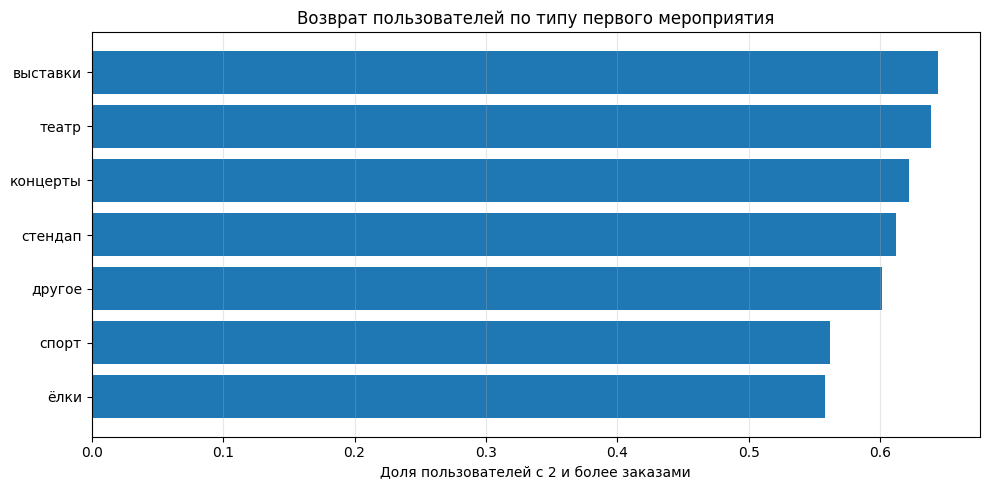

In [180]:
# Сортируем данные по возрастанию доли возврата
event_retention = event_retention.sort_values('return_rate', ascending=False)

# Строим график
plot_retention(
    event_retention,
    'Возврат пользователей по типу первого мероприятия'
)

In [177]:
# Возвраты по типу устройства первого заказа
device_retention = (
    retention_by_segment(
        df_profiles,
        segment_col='first_device'
    )
    .sort_values('return_rate', ascending=False)
)

device_retention

,users_cnt,return_rate
first_device,,
desktop,3746,0.641217
mobile,18108,0.612105


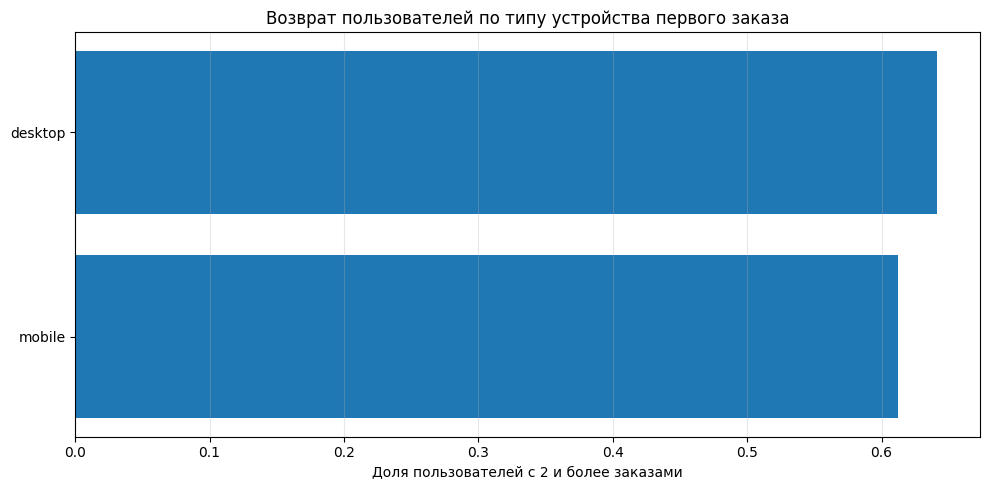

In [179]:
# График по типу устройства
plot_retention(
    device_retention,
    'Возврат пользователей по типу устройства первого заказа'
)

In [186]:
# Возвраты по регионам проведения первого мероприятия
# Берём только TOP-10 регионов по числу пользователей

region_retention = (
    retention_by_segment(
        df_profiles,
        segment_col='first_region_name',
        top_n=10
    )
    .sort_values('return_rate', ascending=False)
)

region_retention

,users_cnt,return_rate
first_region_name,,
Шанырский регион,503,0.673956
Светополянский округ,464,0.661638
Широковская область,1237,0.649151
Североярская область,3799,0.641221
Речиновская область,446,0.639013
Каменевский регион,7159,0.627881
Травяная область,493,0.618661
Яблоневская область,416,0.598558
Малиновоярский округ,529,0.563327


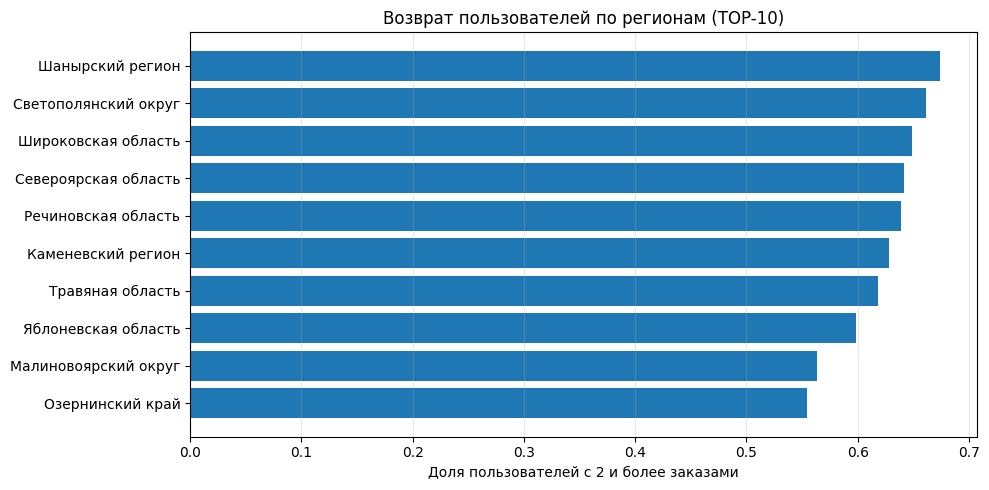

In [187]:
# График по регионам (TOP-10)
plot_retention(
    region_retention,
    'Возврат пользователей по регионам (TOP-10)'
)

In [191]:
# Возвраты по билетным операторам первого заказа
# Берём только TOP-10 операторов по числу пользователей

service_retention = (
    retention_by_segment(
        df_profiles,
        segment_col='first_service_name',
        top_n=10
    )
    .sort_values('return_rate', ascending=False)
)

service_retention

,users_cnt,return_rate
first_service_name,,
Край билетов,459,0.655773
Дом культуры,358,0.648045
Весь в билетах,1304,0.634202
Билеты в руки,2594,0.632228
Прачечная,588,0.629252
Облачко,2194,0.615770
Лови билет!,2848,0.614466
Лучшие билеты,1188,0.613636
Мой билет,2992,0.611631


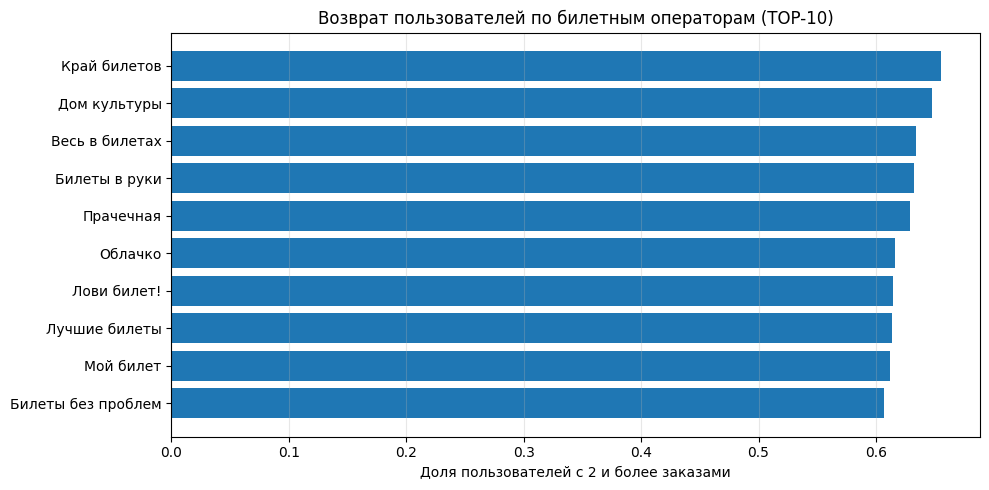

In [192]:
# График по билетным операторам (TOP-10)
plot_retention(
    service_retention,
    'Возврат пользователей по билетным операторам (TOP-10)'
)

### Выводы по анализу возвратов пользователей

В рамках задачи был проанализирован возврат пользователей (доля пользователей, совершивших **два и более заказа**) в зависимости от характеристик их первого заказа. Для корректной интерпретации результатов показатели сравнивались со **средним уровнем возврата по выборке — 61,7%**, а также учитывался размер каждого сегмента.


#### Тип первого мероприятия
Наиболее высокий уровень возврата демонстрируют пользователи, пришедшие на платформу через:
- **выставки (64,4%)**,
- **театр (63,8%)**,
- **концерты (62,2%)**.

Эти типы мероприятий можно рассматривать как **успешные точки входа**, так как их показатели превышают среднее значение по выборке.  
Ниже среднего уровня возврата находятся сегменты **стендап**, **другое**, **спорт** и **ёлки**. При этом выводы по сегменту «ёлки» следует интерпретировать с осторожностью из-за малого числа пользователей.


#### Тип устройства первого заказа
Пользователи, совершившие первый заказ с **десктопных устройств**, возвращаются чаще среднего по выборке (**64,1%** против **61,2%** у мобильных пользователей). Это может указывать на различия в сценариях первого взаимодействия с сервисом, однако данный вывод носит гипотетический характер и требует дополнительной проверки.


#### Регион проведения первого мероприятия
Среди рассмотренных регионов наибольшая доля возврата наблюдается в **Шанырском регионе** и **Светополянском округе**, однако эти сегменты сравнительно небольшие (около 500 пользователей), поэтому показатели могут быть менее устойчивыми.  
Среди крупных по числу пользователей регионов стабильно выше среднего уровня возврата выглядят **Североярская область** и **Каменевский регион**, что позволяет считать результаты по ним более надёжными. Более низкий уровень возврата зафиксирован в **Малиновоярском округе** и **Озернинском крае**.


#### Билетные операторы
Наиболее высокие значения возврата показали пользователи, пришедшие через операторов **«Край билетов»** и **«Дом культуры»**, однако размеры этих сегментов относительно невелики, что требует осторожности при интерпретации.  
При этом крупнейший по числу пользователей оператор **«Билеты без проблем»** имеет показатель возврата ниже среднего по выборке, что является важным наблюдением при оценке качества каналов привлечения.


#### Общий вывод
Анализ подтверждает наличие **успешных точек входа** на платформу, связанных прежде всего с типом первого мероприятия, а также с рядом регионов и билетных операторов. При этом интерпретация результатов должна учитывать размер сегментов: показатели для малочисленных групп могут быть нестабильными и не всегда отражать устойчивые поведенческие паттерны пользователей.


---

#### 4.1.3. Проверка продуктовых гипотез

На данном этапе проводится проверка продуктовых гипотез, сформулированных на основе результатов предыдущего анализа распределения пользователей и их возвратов. Цель — определить, связаны ли характеристики первого заказа и активность регионов с вероятностью повторных покупок на платформе Яндекс Афиша.

В рамках задачи проверяются следующие гипотезы:

- **Гипотеза 1.** Тип первого мероприятия влияет на вероятность возврата: пользователи, совершившие первый заказ на спортивные мероприятия, чаще совершают повторные заказы по сравнению с пользователями, чей первый заказ был связан с концертами.
- **Гипотеза 2.** В более активных регионах (с наибольшим числом пользователей и посещений мероприятий) доля пользователей с повторными заказами выше, чем в регионах с меньшей пользовательской активностью.

Для проверки гипотез пользователи будут сгруппированы:

- по типу первого посещённого мероприятия (для сравнения спорта и концертов);
- по регионам проведения мероприятий из первого заказа с учётом уровня пользовательской активности.

В качестве ключевого показателя будет использована:

- **доля пользователей, совершивших два и более заказа**.

Сравнение значений показателя между выбранными группами позволит оценить, подтверждаются ли выдвинутые гипотезы, а также сделать выводы о влиянии продуктовых и региональных факторов на возврат пользователей.

Результаты проверки гипотез будут использованы для формулирования практических выводов и рекомендаций по развитию продукта и фокусировке маркетинговых усилий.


In [198]:
# ------------------------------------------------------------
# Гипотеза 1. Влияние типа первого мероприятия на возврат
# ------------------------------------------------------------

# Считаем долю пользователей с 2+ заказами
# в разрезе типа первого мероприятия
event_retention = retention_by_segment(
    df_profiles,
    segment_col='first_event_type'
)

# Оставляем только интересующие нас типы мероприятий:
# спорт и концерты
event_retention_filtered = event_retention.loc[
    ['спорт', 'концерты']
]

# Выводим результат
print('ГИПОТЕЗА 1: Возвраты по типу первого мероприятия')
print('-' * 60)
display(event_retention_filtered[['users_cnt', 'return_rate']])

ГИПОТЕЗА 1: Возвраты по типу первого мероприятия
------------------------------------------------------------


,users_cnt,return_rate
first_event_type,,
спорт,801,0.561798
концерты,9643,0.621591


### 📌 Вывод по гипотезе 1

Гипотеза о том, что пользователи, совершившие первый заказ на спортивные мероприятия, возвращаются чаще, чем пользователи, оформившие первый заказ на концерты, **не подтверждается**.

По результатам анализа:

- доля пользователей с повторными заказами среди сегмента **«спорт»** составляет **56,2%**;
- среди пользователей, начавших с **концертов**, доля возвратов выше и составляет **62,2%**.

Таким образом, пользователи, оформившие первый заказ на концерты, **чаще совершают повторные покупки**, чем пользователи спортивных мероприятий.

Также важно учитывать размер сегментов: сегмент «спорт» значительно меньше по числу пользователей по сравнению с сегментом «концерты», что может снижать устойчивость оценки. Тем не менее, даже с учётом этого фактора различие в показателях возврата наблюдается в пользу концертов.

**Итог:** гипотеза 1 отклоняется. Тип первого мероприятия влияет на вероятность возврата, однако более высоким уровнем возвратов характеризуются пользователи, начавшие с концертов, а не со спортивных мероприятий.


In [200]:
# ------------------------------------------------------------
# Гипотеза 2. Влияние активности региона на возврат
# ------------------------------------------------------------

# Считаем возвраты по регионам первого заказа
region_retention = retention_by_segment(
    df_profiles,
    segment_col='first_region_name'
)

# Добавляем ранжирование регионов по числу пользователей
region_retention = region_retention.sort_values(
    'users_cnt',
    ascending=False
)

# Выделяем:
# - ТОП-10 самых активных регионов
# - 10 наименее активных регионов
top_regions = region_retention.head(10)
low_regions = region_retention.tail(10)

# Считаем среднюю долю возвратов
top_regions_return_rate = top_regions['return_rate'].mean()
low_regions_return_rate = low_regions['return_rate'].mean()

# Выводим результаты
print('ГИПОТЕЗА 2: Возвраты по активности регионов')
print('-' * 60)
print(f'Средняя доля возвратов в ТОП-10 регионах: {top_regions_return_rate:.2%}')
print(f'Средняя доля возвратов в менее активных регионах: {low_regions_return_rate:.2%}')

ГИПОТЕЗА 2: Возвраты по активности регионов
------------------------------------------------------------
Средняя доля возвратов в ТОП-10 регионах: 62.28%
Средняя доля возвратов в менее активных регионах: 45.00%


### 📌 Вывод по гипотезе 2

Гипотеза о том, что в регионах с более высокой пользовательской активностью доля повторных заказов выше, **подтверждается**.

Результаты анализа показывают, что:

- средняя доля пользователей с повторными заказами в **ТОП-10 наиболее активных регионах** составляет **62,3%**;
- в **менее активных регионах** данный показатель существенно ниже и составляет **45,0%**.

Таким образом, пользователи из регионов с высокой активностью значительно чаще возвращаются на платформу и совершают повторные покупки. Это может быть связано с более развитой инфраструктурой мероприятий, большим выбором событий и более высокой вовлечённостью аудитории в таких регионах.

При интерпретации результатов следует учитывать, что менее активные регионы, как правило, характеризуются меньшим числом пользователей, из-за чего значения доли возвратов могут быть менее устойчивыми. Тем не менее, наблюдаемая разница между группами регионов является существенной.

**Итог:** гипотеза 2 подтверждается — уровень региональной активности напрямую связан с вероятностью возврата пользователей на платформу.


---

## 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

#### 4.2.1. Анализ связи средней выручки заказа с повторными покупками

На данном этапе анализируется поведение пользователей через финансовые характеристики их заказов, чтобы определить, связана ли средняя выручка сервиса с билета с вероятностью повторного заказа.

Для этого пользователи будут разделены на две группы:
- пользователи, совершившие только один заказ;
- пользователи, совершившие два и более заказов.

Для каждой группы будет изучено распределение средней выручки с билета (`avg_revenue_rub`) с помощью сравнительных гистограмм.

Анализ позволит:
- определить диапазоны средней выручки, в которых концентрируются пользователи каждой группы;
- выявить различия в распределениях между пользователями, вернувшимися на платформу, и пользователями с единичным заказом;
- оценить, связаны ли более высокие значения средней выручки с большей вероятностью повторных покупок.

Для корректного сравнения распределений используются одинаковые интервалы разбиения (bins) и нормировка плотности распределения (`density=True`).


In [203]:
# Формируем группы пользователей по количеству заказов
# Пользователи, которые совершили РОВНО один заказ
one_order_users = (
    df_profiles
    .loc[df_profiles['total_orders'] == 1, 'avg_revenue_rub']
)

In [206]:
# Пользователи, которые совершили ДВА и БОЛЕЕ заказов
repeat_users = (
    df_profiles
    .loc[df_profiles['total_orders'] >= 2, 'avg_revenue_rub']
)

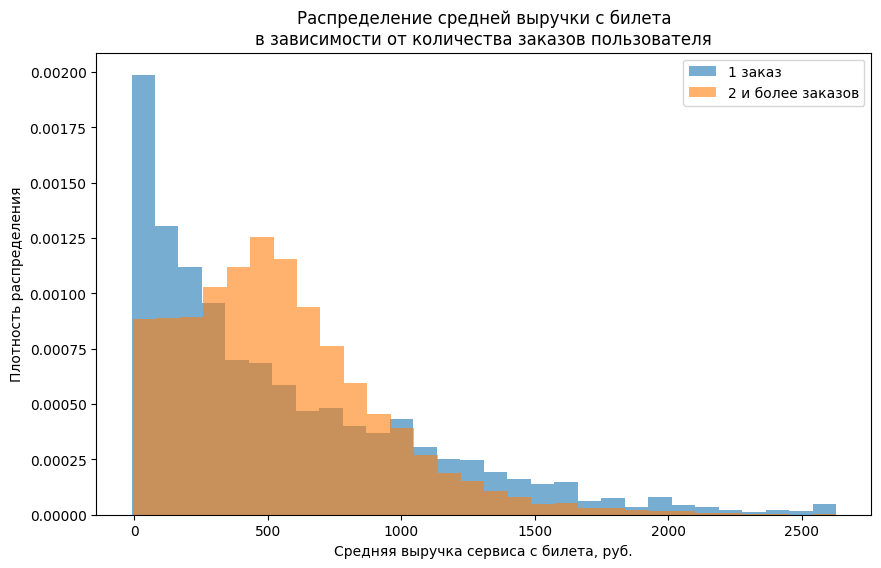

In [208]:
# Сравнительные гистограммы распределения средней выручки
plt.figure(figsize=(10, 6))

plt.hist(
    one_order_users,
    bins=30,
    alpha=0.6,
    density=True,
    label='1 заказ'
)

plt.hist(
    repeat_users,
    bins=30,
    alpha=0.6,
    density=True,
    label='2 и более заказов'
)

plt.xlabel('Средняя выручка сервиса с билета, руб.')
plt.ylabel('Плотность распределения')
plt.title(
    'Распределение средней выручки с билета\n'
    'в зависимости от количества заказов пользователя'
)
plt.legend()
plt.show()

### Вывод

По результатам анализа распределения средней выручки сервиса с билета можно сделать следующие выводы:

- Пользователи, совершившие только один заказ, в основном концентрируются в диапазоне низких значений средней выручки — преимущественно до 300–400 рублей за билет. Распределение для этой группы имеет выраженный пик в области минимальных значений и длинный правый хвост.

- Вернувшиеся пользователи (совершившие два и более заказа) чаще встречаются в диапазоне более высоких значений средней выручки — примерно от 300 до 800 рублей за билет. Распределение для этой группы смещено вправо по сравнению с пользователями с одним заказом.

- Для обеих групп характерна правосторонняя асимметрия распределения, однако у пользователей с повторными заказами доля наблюдений с высокой средней выручкой заметно выше.

Таким образом, можно сделать вывод, что пользователи с более высокой средней выручкой с билета в среднем чаще возвращаются на платформу. Это может свидетельствовать о том, что более «дорогие» заказы связаны с большей вовлечённостью пользователей и более высокой вероятностью повторных покупок.


#### 4.2.2. Сравнение средней выручки заказа в зависимости от глубины вовлечённости пользователя

На данном этапе проводится более детальный анализ финансового поведения пользователей в зависимости от количества совершённых заказов. Цель — определить, различается ли средняя выручка с заказа у пользователей с разной степенью вовлечённости.

Для этого все пользователи будут разделены на две группы:
- пользователи, совершившие от 2 до 4 заказов;
- пользователи, совершившие 5 и более заказов.

Для каждой группы будет проанализировано распределение средней выручки с заказа (`avg_revenue_rub`) с использованием сравнительных гистограмм.

Анализ позволит:
- определить, в каких диапазонах средней выручки концентрируются пользователи каждой группы;
- выявить возможные сдвиги распределений между умеренно активными и высоко вовлечёнными пользователями;
- оценить, сопровождается ли рост числа заказов изменением средней выручки с одного заказа.

Для корректного сопоставления распределений используются одинаковые интервалы разбиения (bins) и нормировка плотности распределения (`density=True`), что позволяет сравнивать форму распределений независимо от различий в численности групп.


In [209]:
# Пользователи, совершившие от 2 до 4 заказов включительно
# Берём показатель средней выручки с билета
medium_users = df_profiles.loc[
    (df_profiles['total_orders'] >= 2) & (df_profiles['total_orders'] <= 4),
    'avg_revenue_rub'
]

In [210]:
# Пользователи, совершившие 5 и более заказов
# Также берём показатель средней выручки с билета
high_users = df_profiles.loc[
    df_profiles['total_orders'] >= 5,
    'avg_revenue_rub'
]

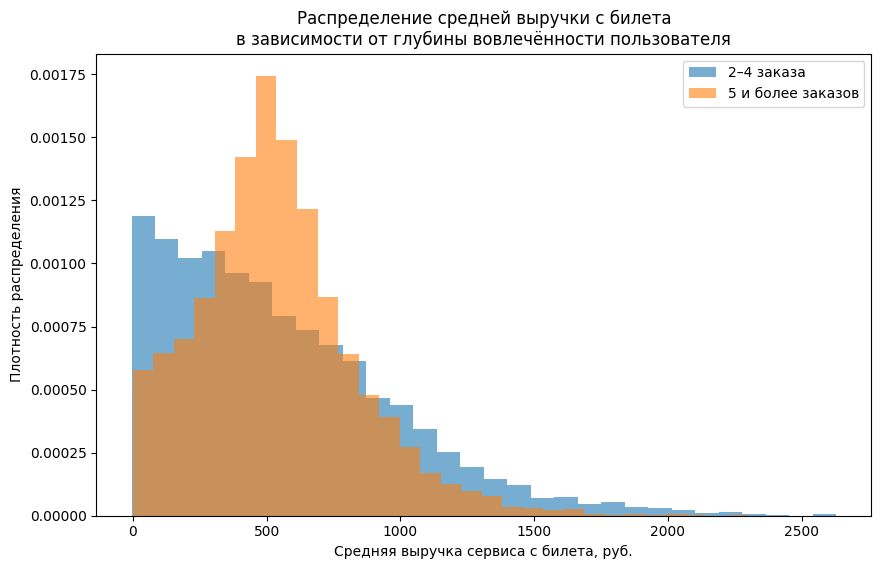

In [212]:
# Строим сравнительные гистограммы распределений
plt.figure(figsize=(10, 6)) 

# Гистограмма для пользователей с 2–4 заказами
plt.hist(
    medium_users,   
    bins=30,         
    alpha=0.6,         
    density=True,     
    label='2–4 заказа'
)

# Гистограмма для пользователей с 5 и более заказами
plt.hist(
    high_users, 
    bins=30,         
    alpha=0.6,       
    density=True,    
    label='5 и более заказов'
)

plt.xlabel('Средняя выручка сервиса с билета, руб.')
plt.ylabel('Плотность распределения')
plt.title(
    'Распределение средней выручки с билета\n'
    'в зависимости от глубины вовлечённости пользователя'
)
plt.legend()
plt.show()

### Вывод

Распределения средней выручки с заказа для пользователей, совершивших 2–4 заказа и 5 и более заказов, в целом имеют схожую форму, однако между группами наблюдаются заметные различия.

Пользователи с 5 и более заказами в большей степени концентрируются в среднем диапазоне значений выручки (примерно 400–700 руб.), при этом их распределение более компактное и менее растянутое. Это говорит о более стабильном уровне средней выручки с заказа у высоко вовлечённых пользователей.

У пользователей, совершивших 2–4 заказа, распределение более широкое: чаще встречаются как более низкие значения средней выручки, так и экстремально высокие значения (длинный правый хвост). Это указывает на большую вариативность покупательского поведения в данной группе.

В целом можно сделать вывод, что значимых различий по уровню средней выручки с заказа между группами нет, однако пользователи с 5 и более заказами демонстрируют более устойчивый и предсказуемый уровень средней выручки, тогда как у пользователей с 2–4 заказами выручка более неоднородна.


#### 4.2.3. Влияние среднего количества билетов в заказе на вероятность повторной покупки

На данном этапе проводится анализ связи между средним количеством билетов в заказе и вероятностью повторной покупки. Цель — определить, отличается ли поведение пользователей с разным средним числом билетов в заказе с точки зрения возвратов на платформу.

Для начала будет изучено распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`). Это позволит понять, в каких диапазонах значений сосредоточено большинство пользователей и присутствуют ли экстремальные или редкие значения.

Далее все пользователи будут разделены на сегменты в зависимости от среднего количества билетов в заказе:
- от 1 до 2 билетов;
- от 2 до 3 билетов;
- от 3 до 5 билетов;
- 5 и более билетов.

Для каждого сегмента будет рассчитано:
- общее число пользователей;
- доля пользователей, совершивших повторный заказ.

Анализ позволит:
- оценить, равномерно ли распределены пользователи между сегментами или наблюдается концентрация в отдельных диапазонах;
- выявить сегменты с повышенной или пониженной долей повторных покупок;
- определить, связано ли увеличение среднего количества билетов в заказе с ростом или снижением вероятности возврата пользователя.

При интерпретации результатов будет учитываться размер сегментов, так как сегменты с малым числом пользователей могут демонстрировать нестабильные и менее надёжные значения доли повторных покупок.


In [225]:
# Функция определяет сегмент пользователя
# на основе среднего количества билетов в заказе

def tickets_segment(x):
    if 1 <= x < 2:
        return '1–2 билета'
    elif 2 <= x < 3:
        return '2–3 билета'
    elif 3 <= x < 5:
        return '3–5 билетов'
    else:
        return '5+ билетов'

In [226]:
# Добавляем сегмент по среднему количеству билетов
# в профиль пользователя

profiles['tickets_segment'] = (
    profiles['avg_tickets_count']
    .apply(tickets_segment)
)

In [227]:
# Для каждого сегмента считаем:
# - количество пользователей
# - долю пользователей с повторной покупкой (2+ заказа)

segment_stats = (
    profiles
    .groupby('tickets_segment', observed=True)
    .agg(
        users_count=('user_id', 'nunique'),
        return_rate=('is_two', 'mean')
    )
    .reset_index()
)

In [228]:
# Сортируем сегменты по убыванию размера
# для удобства интерпретации

segment_stats = segment_stats.sort_values(
    'users_count',
    ascending=False
)

segment_stats

,tickets_segment,users_count,return_rate
1,2–3 билета,9706,0.741500
2,3–5 билетов,9068,0.543008
0,1–2 билета,2419,0.513022
3,5+ билетов,661,0.187595


### Вывод

Распределение пользователей по сегментам среднего количества билетов в заказе является неравномерным. Основная масса пользователей сосредоточена в сегментах от 2 до 3 билетов и от 3 до 5 билетов, на которые приходится подавляющая часть аудитории. Сегменты с малым и очень большим средним числом билетов (1–2 и 5+ билетов) представлены существенно меньшим числом пользователей.

Наиболее высокая доля повторных покупок наблюдается в сегменте пользователей со средним количеством билетов от 2 до 3. Это может указывать на оптимальный сценарий использования сервиса, при котором пользователи чаще возвращаются на платформу для повторных заказов.

По мере роста среднего количества билетов в заказе выше 3 наблюдается снижение доли повторных покупок. Особенно низкое значение показателя зафиксировано в сегменте 5 и более билетов, что может свидетельствовать о разовых, событийных покупках (например, для групп или корпоративных мероприятий), не предполагающих регулярных повторных заказов.

Сегмент пользователей с 1–2 билетами также демонстрирует относительно низкую долю возвратов по сравнению с наиболее активным сегментом, что может быть связано с эпизодическим характером посещения мероприятий.

Таким образом, связь между средним количеством билетов в заказе и вероятностью повторной покупки носит нелинейный характер: максимальная вероятность возврата наблюдается при среднем количестве билетов от 2 до 3, тогда как как слишком малое, так и слишком большое число билетов в заказе ассоциируется с более низкой долей повторных покупок.


---

### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

На данном этапе проводится анализ временных параметров, связанных с первым заказом пользователя, с целью определить, влияют ли они на вероятность совершения повторной покупки.

В рамках анализа будут рассмотрены следующие характеристики:
- день недели, в который была совершена первая покупка;
- время с момента первой покупки (лайфтайм пользователя);
- средний интервал между покупками у пользователей с повторными заказами.

#### 4.3.1. Влияние дня недели первой покупки на повторные заказы

В данной задаче анализируется связь между днём недели, в который пользователь совершил первый заказ, и его дальнейшим поведением на платформе.

Для этого по дате первого заказа будет определён день недели первой покупки. Далее для каждого дня недели будет рассчитано:
- общее количество пользователей;
- доля пользователей, совершивших повторный заказ.

Полученные результаты будут визуализированы, что позволит наглядно сравнить поведение пользователей, впервые пришедших на платформу в разные дни недели.

Анализ позволит ответить на вопрос: **влияет ли день недели, в который была совершена первая покупка, на вероятность возврата пользователя и совершения повторного заказа.**


In [230]:
# Выделяем день недели первой покупки
# Monday = 0, Sunday = 6
df_profiles['first_order_weekday'] = df_profiles['first_order_dt'].dt.dayofweek

In [246]:
# Создаём словарь для сопоставления числовых значений дней недели
# (0 — понедельник, 6 — воскресенье) с их текстовыми названиями
weekday_map = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}
# Преобразуем числовое значение дня недели в читаемое название
# и сохраняем результат в новый столбец weekday_name
df_profiles['weekday_name'] = df_profiles['first_order_weekday'].map(weekday_map)

In [247]:
# Группируем пользователей по дню недели первой покупки
weekday_retention = (
    df_profiles
    .groupby('weekday_name')  # объединяем данные по названию дня недели
    .agg(
        # users_cnt — количество уникальных пользователей,
        # совершивших первую покупку в данный день недели
        users_cnt=('user_id', 'nunique'),
        
        # return_rate — доля пользователей с повторными заказами:
        # считаем, у кого общее число заказов >= 2,
        # и берём среднее значение (True = 1, False = 0)
        return_rate=('total_orders', lambda x: (x >= 2).mean())
    )
    .reset_index()  # возвращаем weekday_name из индекса в обычный столбец
)

weekday_retention


,weekday_name,users_cnt,return_rate
0,Воскресенье,2810,0.604982
1,Вторник,3189,0.620571
2,Понедельник,2943,0.632008
3,Пятница,3261,0.598589
4,Среда,3072,0.623698
5,Суббота,3459,0.642382
6,Четверг,3120,0.595192


In [255]:
# Задаём логический порядок дней недели (от понедельника к воскресенью)
weekday_order = [
    'Понедельник',
    'Вторник',
    'Среда',
    'Четверг',
    'Пятница',
    'Суббота',
    'Воскресенье'
]

# Преобразуем столбец weekday_name в категориальный тип
# с заранее заданным порядком категорий
weekday_retention['weekday_name'] = pd.Categorical(
    weekday_retention['weekday_name'],  # столбец с названиями дней недели
    categories=weekday_order,            # желаемый порядок дней
    ordered=True                         # указываем, что порядок важен
)

# Сортируем таблицу по дню недели в хронологическом порядке,
# а не по алфавиту
weekday_retention = weekday_retention.sort_values('weekday_name')

# Выводим итоговую таблицу, упорядоченную по дням недели
weekday_retention


,weekday_name,users_cnt,return_rate
2,Понедельник,2943,0.632008
1,Вторник,3189,0.620571
4,Среда,3072,0.623698
6,Четверг,3120,0.595192
3,Пятница,3261,0.598589
5,Суббота,3459,0.642382
0,Воскресенье,2810,0.604982


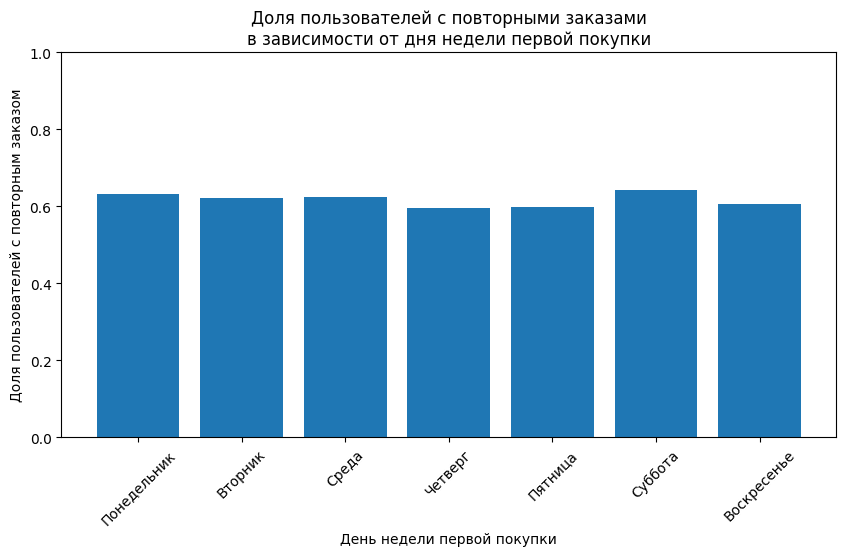

In [256]:
# Визуализация
plt.figure(figsize=(10, 5))

plt.bar(
    weekday_retention['weekday_name'],
    weekday_retention['return_rate']
)

plt.title(
    'Доля пользователей с повторными заказами\n'
    'в зависимости от дня недели первой покупки'
)
plt.xlabel('День недели первой покупки')
plt.ylabel('Доля пользователей с повторным заказом')

plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.show()

### Выводы

Анализ показал, что день недели, в который была совершена первая покупка, оказывает **умеренное влияние** на вероятность повторного заказа.

Наиболее высокая доля пользователей с повторными покупками наблюдается у тех, кто совершил первый заказ в **субботу** (≈64%), а также в **понедельник** (≈63%). Наименьшая доля возвратов зафиксирована у пользователей, сделавших первую покупку в **четверг** и **пятницу** (около 59–60%).

При этом различия между днями недели не являются резкими: разброс значений составляет около **4–5 процентных пунктов**, а размеры пользовательских сегментов по дням недели сопоставимы, что делает выводы устойчивыми.

Таким образом, день недели первой покупки может рассматриваться как **второстепенный фактор**, влияющий на вероятность возврата пользователя, но сам по себе не определяет поведение клиентов.


---

#### 4.3.2. Влияние среднего интервала между заказами на удержание клиентов

В данной задаче анализируется, как средний интервал времени между заказами связан с уровнем вовлечённости и удержанием пользователей на платформе.

Для этого пользователи будут разделены на две группы в зависимости от количества совершённых заказов:
- пользователи, совершившие от 2 до 4 заказов;
- пользователи, совершившие 5 и более заказов.

Для каждой группы будет рассчитано среднее значение интервала между заказами — показатель, отражающий, как часто пользователь возвращается на платформу для совершения следующей покупки.

Дополнительно будет изучено распределение среднего интервала между заказами и его связь с вероятностью повторного заказа. Это позволит:
- сравнить поведение умеренно активных и высоко вовлечённых пользователей;
- определить, характеризуются ли более лояльные пользователи меньшими промежутками между покупками;
- сделать вывод о том, влияет ли частота заказов (через средний интервал между ними) на удержание клиентов.

Результаты анализа помогут оценить, является ли средний интервал между заказами важным фактором возврата пользователей и роста их долгосрочной ценности.


In [261]:
# Берём только пользователей, у которых было 2 и более заказов
interval_df = df_profiles[df_profiles['total_orders'] >= 2].copy()

In [266]:
# Создаём группы:
# 2–4 заказа и 5 и более заказов
interval_df['orders_group'] = np.where(
    interval_df['total_orders'] >= 5,
    '5 и более заказов',
    '2–4 заказа'
)

In [270]:
# Сравниваем средний интервал между заказами в двух группах
interval_comparison = (
    interval_df
    .groupby('orders_group')
    .agg(
        # Количество уникальных пользователей в группе
        users_cnt=('user_id', 'nunique'),
        
        # Средний интервал между заказами (в днях)
        avg_days_between_orders=('avg_days_since_prev', 'mean'),
        
        # Доля пользователей с 5 и более заказами
        # Используется как индикатор более высокого удержания
        return_rate=('total_orders', lambda x: (x >= 5).mean())
    )
    .reset_index()
)

interval_comparison

,orders_group,users_cnt,avg_days_between_orders,return_rate
0,2–4 заказа,7147,21.329939,0.0
1,5 и более заказов,6339,9.578355,1.0


### Выводы

Анализ среднего интервала между заказами показал заметные различия
в поведении пользователей с разным уровнем вовлечённости.

Пользователи, совершившие **5 и более заказов**, возвращаются на платформу
значительно чаще: средний интервал между их покупками составляет около
**9,6 дня**. Для пользователей с **2–4 заказами** этот показатель почти
в два раза выше — около **21,3 дня**.

Вероятность повторного заказа также существенно различается между группами:
для пользователей с **5 и более заказов** она максимальна, тогда как среди
пользователей с 2–4 заказами дальнейшее увеличение активности не наблюдается.
Это подчёркивает связь между частотой покупок и уровнем удержания клиентов.

Таким образом, можно сделать вывод, что **чем меньше средний интервал между
заказами, тем выше вероятность повторных покупок и долгосрочного удержания
пользователя**. Средний интервал между заказами является важным индикатором
лояльности и может быть использован для оценки качества удержания клиентов.


---

### 4.4. Корреляционный анализ количества покупок и признаков пользователя

На данном этапе проводится корреляционный анализ, направленный на выявление связи между количеством заказов пользователя (`total_orders`) и характеристиками его профиля, а также параметрами первого заказа.

В качестве меры зависимости используется коэффициент **phi_k** — универсальный коэффициент корреляции, который позволяет корректно оценивать связи:
- между числовыми признаками;
- между категориальными признаками;
- между числовыми и категориальными признаками.

Это делает phi_k удобным инструментом для анализа пользовательских профилей, где признаки имеют разную природу.

В рамках анализа будут рассмотрены следующие шаги:

1. **Расчёт корреляций с числом заказов**  
   Для всех признаков профиля пользователя и параметров первого заказа будет рассчитан коэффициент корреляции phi_k с целевой переменной `total_orders`.  
   Для числовых признаков при необходимости будет использован параметр `interval_cols`, чтобы корректно учитывать интервальную шкалу данных.

2. **Анализ распределения `total_orders`**  
   Если значения корреляции окажутся близкими к нулю, дополнительно будет изучено распределение количества заказов.  
   Такая ситуация возможна, если в данных преобладает одно значение (например, большинство пользователей совершают только один заказ), что снижает чувствительность корреляционного анализа.

3. **Сегментация пользователей по числу заказов**  
   Чтобы повысить информативность анализа, пользователи будут разделены на три сегмента:
   - пользователи с **1 заказом**;
   - пользователи с **2–4 заказами**;
   - пользователи с **5 и более заказами**.

   После этого корреляционный анализ будет повторён уже для сегментированной целевой переменной.

4. **Визуализация результатов**  
   Полученные коэффициенты корреляции будут представлены в виде тепловой карты, что позволит наглядно сравнить силу связи различных признаков с количеством заказов.

Результаты анализа позволят ответить на вопрос:  
**какие характеристики профиля пользователя и первого заказа наиболее тесно связаны с числом совершённых покупок**, а также определить признаки, которые потенциально могут использоваться для сегментации пользователей и улучшения продуктовых решений.


In [272]:
# Формируем датафрейм только с нужными признаками
# total_orders — целевая переменная
corr_df = df_profiles[
    [
        'total_orders',
        'first_event_type',
        'first_device',
        'first_region_name',
        'first_service_name',
        'first_order_weekday',
        'avg_revenue_rub',
        'avg_tickets_count',
        'avg_days_since_prev'
    ]
].copy()

In [279]:
# Указываем интервальные (числовые) признаки
interval_cols = [
    'total_orders',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_since_prev'
]

# Считаем матрицу корреляций phi_k
phik_corr = corr_df.phik_matrix(interval_cols=interval_cols)

phik_corr

,total_orders,first_event_type,first_device,first_region_name,first_service_name,first_order_weekday,avg_revenue_rub,avg_tickets_count,avg_days_since_prev
total_orders,1.000000,0.000000,0.000000,0.127203,0.111114,0.055527,0.000000,0.000000,0.000000
first_event_type,0.000000,1.000000,0.061082,0.511205,0.589318,0.084455,0.326968,0.095147,0.049769
first_device,0.000000,0.061082,1.000000,0.115952,0.082769,0.073585,0.075204,0.055322,0.017498
first_region_name,0.127203,0.511205,0.115952,1.000000,0.696781,0.156986,0.362065,0.164722,0.077842
first_service_name,0.111114,0.589318,0.082769,0.696781,1.000000,0.068829,0.379551,0.067866,0.055858
first_order_weekday,0.055527,0.084455,0.073585,0.156986,0.068829,1.000000,0.028501,0.021588,0.000000
avg_revenue_rub,0.000000,0.326968,0.075204,0.362065,0.379551,0.028501,1.000000,0.461196,0.091285
avg_tickets_count,0.000000,0.095147,0.055322,0.164722,0.067866,0.021588,0.461196,1.000000,0.102593
avg_days_since_prev,0.000000,0.049769,0.017498,0.077842,0.055858,0.000000,0.091285,0.102593,1.000000


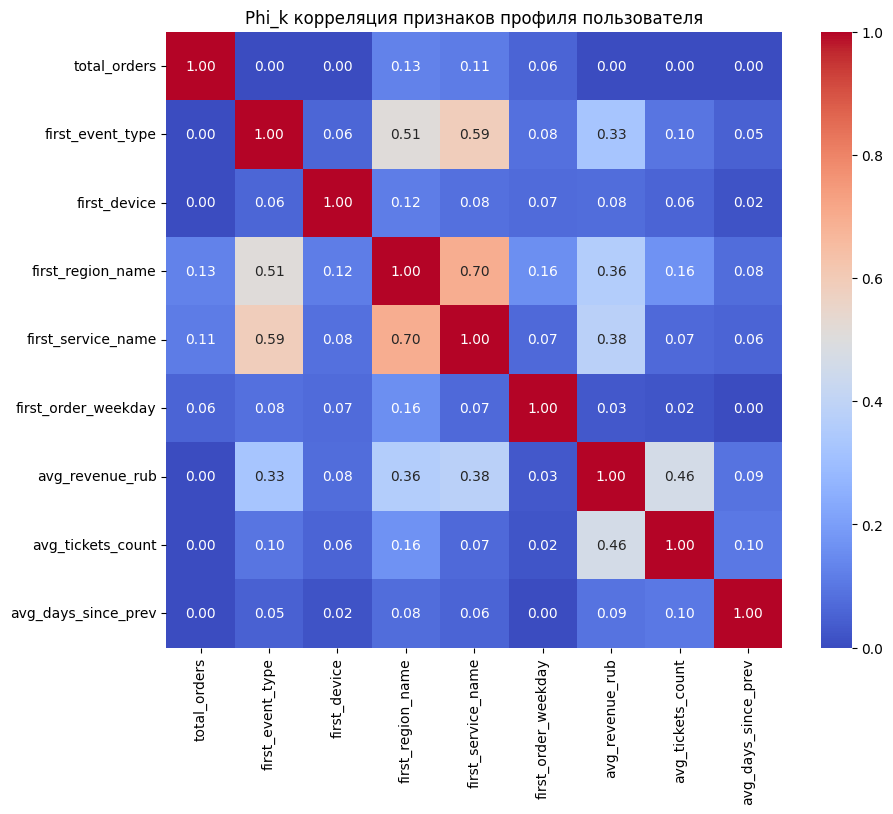

In [281]:
# Строим тепловую карту корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(
    phik_corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True
)

plt.title('Phi_k корреляция признаков профиля пользователя')
plt.show()

In [282]:
# Проверяем распределение количества заказов
df_profiles['total_orders'].value_counts(normalize=True)

total_orders
1       0.382905
2       0.163448
3       0.099524
4       0.064061
5       0.044431
          ...   
3375    0.000046
443     0.000046
538     0.000046
551     0.000046
2421    0.000046
Name: proportion, Length: 329, dtype: float64

In [300]:
# Создаём сегменты пользователей по количеству заказов
df_profiles['orders_segment'] = df_profiles['total_orders'].apply(
    lambda x: '1 заказ' if x == 1 else ('2–4 заказа' if x <= 4 else '5 и более')
)

In [294]:
segment_df = df_profiles[df_profiles['orders_segment'] == segment][
    [
        'first_event_type',
        'first_device',
        'first_region_name',
        'first_service_name',
        'first_order_weekday',
        'avg_revenue_rub',
        'avg_tickets_count',
        'avg_days_since_prev'
    ]
]

segment_corr[segment] = segment_df.phik_matrix(
    interval_cols=interval_cols
)

In [299]:
for segment, corr_matrix in segment_corr.items():
    print(f'\nPhi_k корреляция — сегмент: {segment}')
    display(corr_matrix.round(2))



Phi_k корреляция — сегмент: 1 заказ


,first_event_type,first_device,first_region_name,first_service_name,first_order_weekday,avg_revenue_rub,avg_tickets_count,avg_days_since_prev
first_event_type,1.00,0.06,0.51,0.59,0.09,0.38,0.11,0.52
first_device,0.06,1.00,0.10,0.08,0.07,0.09,0.07,0.00
first_region_name,0.51,0.10,1.00,0.67,0.14,0.39,0.19,0.94
first_service_name,0.59,0.08,0.67,1.00,0.06,0.45,0.03,0.85
first_order_weekday,0.09,0.07,0.14,0.06,1.00,0.00,0.02,0.00
avg_revenue_rub,0.38,0.09,0.39,0.45,0.00,1.00,0.46,0.00
avg_tickets_count,0.11,0.07,0.19,0.03,0.02,0.46,1.00,0.00
avg_days_since_prev,0.52,0.00,0.94,0.85,0.00,0.00,0.00,1.00



Phi_k корреляция — сегмент: 2–4 заказа


,total_orders,first_event_type,first_device,first_region_name,first_service_name,first_order_weekday,avg_revenue_rub,avg_tickets_count,avg_days_since_prev
total_orders,1.00,0.00,0.01,0.01,0.07,0.00,0.11,0.37,0.39
first_event_type,0.00,1.00,0.06,0.48,0.58,0.07,0.33,0.08,0.06
first_device,0.01,0.06,1.00,0.12,0.08,0.07,0.06,0.04,0.03
first_region_name,0.01,0.48,0.12,1.00,0.68,0.14,0.32,0.00,0.13
first_service_name,0.07,0.58,0.08,0.68,1.00,0.07,0.40,0.00,0.08
first_order_weekday,0.00,0.07,0.07,0.14,0.07,1.00,0.01,0.00,0.00
avg_revenue_rub,0.11,0.33,0.06,0.32,0.40,0.01,1.00,0.32,0.18
avg_tickets_count,0.37,0.08,0.04,0.00,0.00,0.00,0.32,1.00,0.11
avg_days_since_prev,0.39,0.06,0.03,0.13,0.08,0.00,0.18,0.11,1.00



Phi_k корреляция — сегмент: 5 и более


,first_event_type,first_device,first_region_name,first_service_name,first_order_weekday,avg_revenue_rub,avg_tickets_count,avg_days_since_prev
first_event_type,1.00,0.07,0.55,0.59,0.10,0.24,0.11,0.10
first_device,0.07,1.00,0.15,0.10,0.07,0.07,0.03,0.00
first_region_name,0.55,0.15,1.00,0.70,0.24,0.36,0.20,0.10
first_service_name,0.59,0.10,0.70,1.00,0.12,0.24,0.08,0.00
first_order_weekday,0.10,0.07,0.24,0.12,1.00,0.07,0.04,0.07
avg_revenue_rub,0.24,0.07,0.36,0.24,0.07,1.00,0.35,0.19
avg_tickets_count,0.11,0.03,0.20,0.08,0.04,0.35,1.00,0.09
avg_days_since_prev,0.10,0.00,0.10,0.00,0.07,0.19,0.09,1.00


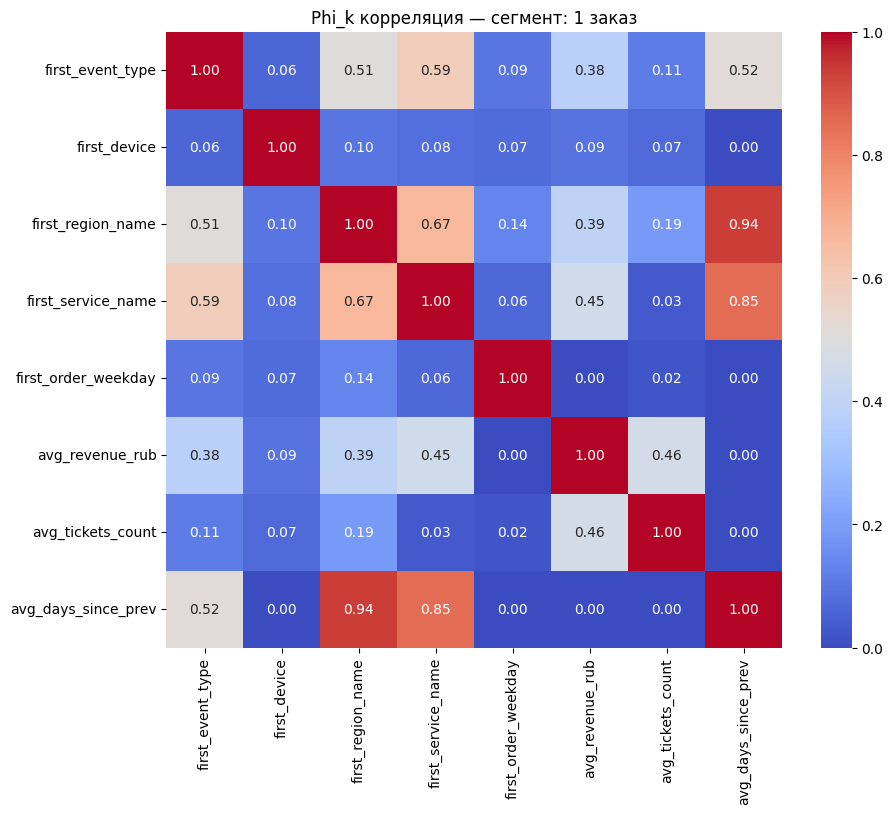

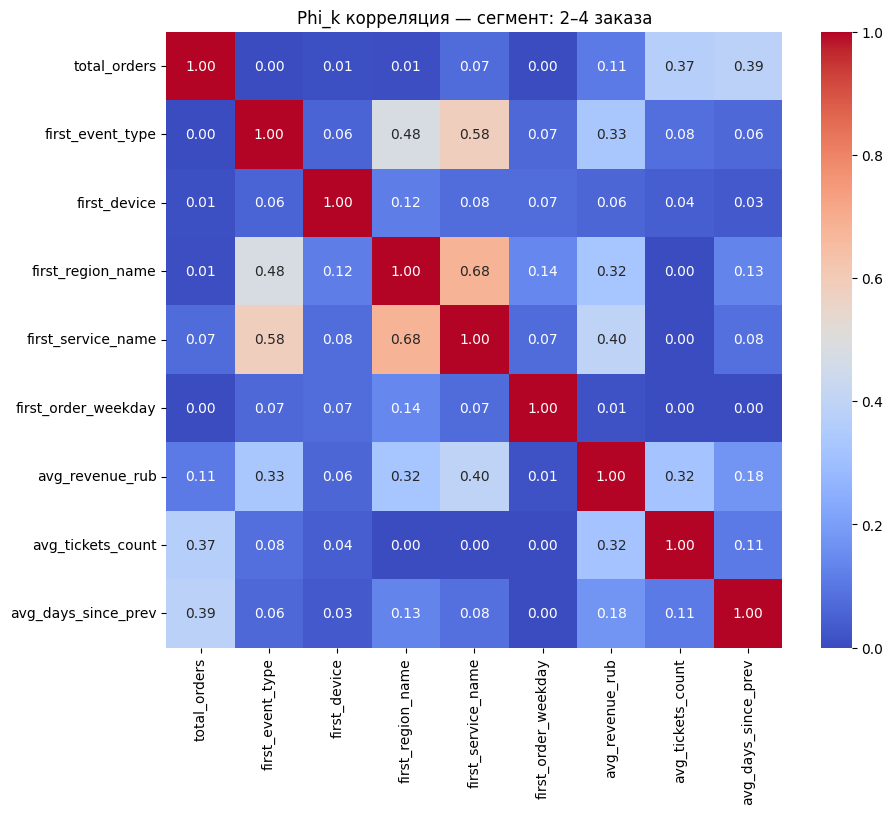

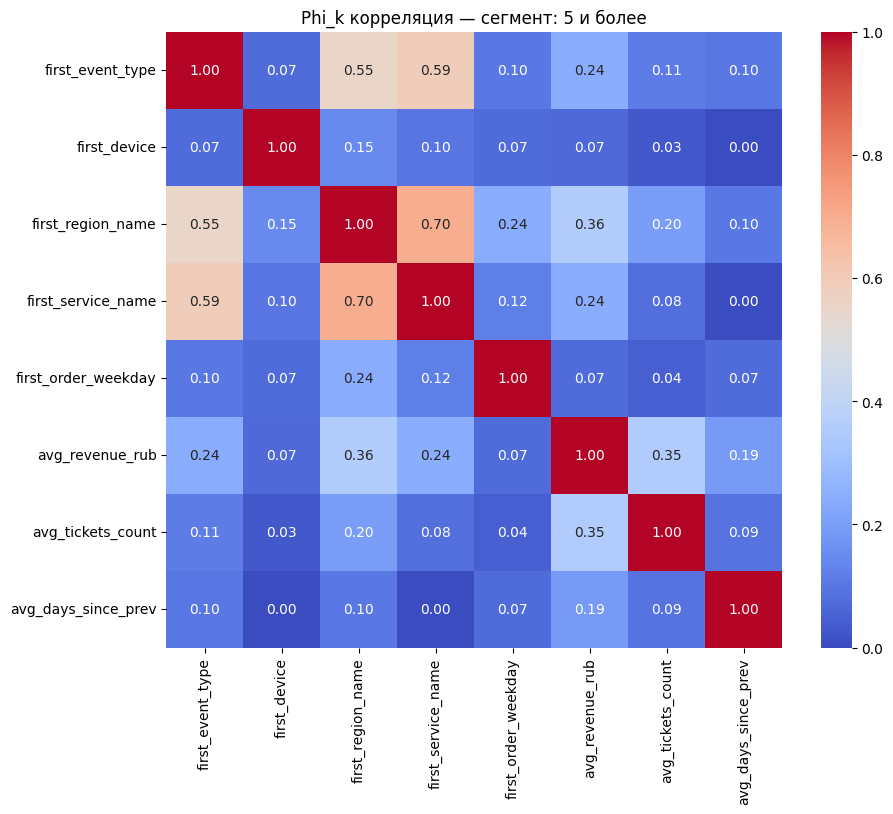

In [295]:
# Визуализируем корреляции для каждого сегмента
for segment, corr_matrix in segment_corr.items():
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True
    )
    
    plt.title(f'Phi_k корреляция — сегмент: {segment}')
    plt.show()


## Вывод

### Общий анализ по всей выборке
- Коэффициенты phi_k между `total_orders` и большинством признаков профиля пользователя оказались **близкими к нулю**.
- Это связано с **сильной асимметрией распределения `total_orders`**: около 38% пользователей совершили только один заказ.
- При таком перекосе корреляционный анализ на всей выборке не позволяет выявить устойчивые зависимости, что является ожидаемым эффектом, а не ошибкой расчётов.

---

### Анализ по сегментам пользователей

#### Сегмент: **1 заказ**
- Значимых связей с количеством заказов не выявлено, так как внутри сегмента отсутствует вариативность целевой переменной.
- Наблюдаются сильные корреляции между характеристиками первого заказа:
  - регион ↔ билетный оператор,
  - регион ↔ тип мероприятия.
- Данный сегмент отражает **структуру входа пользователей**, но не объясняет факторы повторных покупок.

---

#### Сегмент: **2–4 заказа**
- Это наиболее информативный сегмент для анализа факторов роста числа заказов.
- Наиболее связанные с `total_orders` признаки:
  - **`avg_days_since_prev`** — умеренная положительная связь (≈ 0.39);
  - **`avg_tickets_count`** — умеренная положительная связь (≈ 0.37).
- Интерпретация:
  - пользователи, совершающие заказы **чаще** (меньший интервал между покупками),
    как правило, имеют большее общее число заказов;
  - более крупные заказы по количеству билетов ассоциированы с более высокой вовлечённостью.

---

#### Сегмент: **5 и более заказов**
- Влияние характеристик первого заказа заметно снижается.
- Основную роль начинают играть **поведенческие и финансовые показатели**:
  - связь между средней выручкой и количеством билетов в заказе;
  - слабая, но устойчивая связь между выручкой и интервалом между заказами.
- Поведение пользователей в этом сегменте более стабильно, а количество заказов определяется накопленным опытом взаимодействия с сервисом.

---

### Итоговый вывод
- Характеристики первого заказа и профиля пользователя **слабо связаны** с количеством покупок при анализе всей выборки.
- После сегментации выявлено, что:
  - для пользователей с 2–4 заказами ключевыми факторами являются **частота покупок** и **размер заказа**;
  - для высоко вовлечённых пользователей (5+ заказов) решающую роль играют **поведенческие и финансовые метрики**, а не параметры первого заказа.
- Таким образом, количество заказов в большей степени определяется **динамикой поведения пользователя**, а не характеристиками его первого взаимодействия с сервисом.


---

## 5. Общие выводы и рекомендации

### Данные и их подготовка

В работе использовались данные о заказах пользователей за период с **1 июня по 31 октября 2024 года**.  
Датасет содержит **290 611 заказов** и **21 854 уникальных пользователя**. Каждая строка соответствует одному заказу.

Перед анализом были выполнены основные шаги подготовки данных:
- выручка, указанная в рублях и тенге, была приведена к единой валюте (рубли) с учётом курса на дату заказа; результат сохранён в столбце `revenue_rub`;
- пропуски обнаружены только в столбце `days_since_prev` (около 7.6%) и соответствуют первым заказам пользователей;
- типы данных были оптимизированы (категориальные признаки переведены в `category`, числовые — в более компактные форматы), что позволило сократить объём памяти почти в 2 раза;
- дубликаты заказов отсутствуют;
- для снижения влияния экстремальных значений выполнена фильтрация выбросов по 99-му перцентилю, при этом удалено менее 1% заказов.

В результате получен корректный и устойчивый набор данных, подходящий для анализа.

---

### Основные результаты анализа

**Пользовательская активность**
- Распределение количества заказов на пользователя сильно неравномерно: медиана составляет **2 заказа**, у 75% пользователей — не более **5 заказов**.
- Более **60% пользователей** совершают повторные покупки, а около **30%** — **5 и более заказов**, что говорит о наличии лояльной аудитории.
- При этом существует небольшая группа очень активных пользователей с аномально большим числом заказов.

**Первый заказ и точки входа**
- Чаще всего первый заказ совершается на **концерты** и с **мобильных устройств**.
- Основной поток пользователей сосредоточен в нескольких регионах и у ограниченного числа билетных операторов.
- Наиболее высокий уровень возвратов показывают пользователи, начавшие с **концертов, театра и выставок**.

**Выручка и количество билетов**
- Пользователи с повторными покупками в среднем имеют более высокую выручку с билета, чем пользователи с одним заказом.
- Существенных различий по средней выручке с заказа между пользователями с **2–4** и **5+ заказами** не выявлено, однако у более активных пользователей выручка более стабильна.
- Наибольшая доля возвратов наблюдается у пользователей со средним количеством **2–3 билета** в заказе. Как меньшие, так и большие значения чаще связаны с разовыми покупками.

**Временные факторы**
- День недели первой покупки влияет на возврат незначительно: немного выше удержание у пользователей, начавших покупки в выходные или в понедельник.
- Средний интервал между заказами тесно связан с вовлечённостью: пользователи с **5 и более заказами** возвращаются почти в 2 раза быстрее, чем пользователи с **2–4 заказами**.

**Корреляционный анализ**
- На всей выборке явных связей между количеством заказов и характеристиками профиля пользователя не выявлено.
- После разделения пользователей на сегменты оказалось, что:
  - для пользователей с **2–4 заказами** важны частота покупок и размер заказа;
  - для пользователей с **5 и более заказами** основную роль играют поведенческие и финансовые показатели.
- В целом количество заказов определяется не параметрами первого заказа, а тем, как пользователь ведёт себя со временем.

---

### Рекомендации

1. **Сосредоточиться на пользователях с 2–4 заказами**  
   Это промежуточный сегмент между новыми и лояльными клиентами. Он лучше всего реагирует на улучшения сервиса и маркетинговые стимулы и даёт наибольший потенциал роста общей выручки.

2. **Сокращать паузы между заказами**  
   Чем чаще пользователь возвращается, тем выше вероятность дальнейших покупок. Для этого можно использовать напоминания, персональные предложения и рекомендации.

3. **Поддерживать наиболее популярный сценарий покупки**  
   Пользователи, которые в среднем покупают **2–3 билета**, возвращаются чаще. Этот сценарий стоит учитывать при настройке интерфейса и предложений.

4. **Развивать эффективные точки входа**  
   Концерты, театр и выставки показывают лучшие показатели возврата и могут использоваться как приоритетные каналы привлечения новых пользователей.

5. **Выделить сверхактивных пользователей в отдельный сегмент**  
   Небольшая группа пользователей с очень большим числом заказов сильно отличается по поведению и должна анализироваться отдельно, а не в составе общей аудитории.

В целом анализ показывает, что удержание пользователей определяется не столько первым заказом, сколько регулярностью и привычкой к повторным покупкам. Именно на это стоит делать основной акцент при развитии продукта.
